### Installation & Imports

In [ ]:
# ============================================================================
# CELL 1: INSTALL PACKAGES & AUTO-RESTART
# ============================================================================

!pip uninstall -y -q bertopic sentence-transformers umap-learn hdbscan scikit-learn
!pip install -q "scikit-learn==1.4.2" "umap-learn==0.5.6" "hdbscan==0.8.40" \
             "sentence-transformers==3.0.1" "bertopic==0.16.4"
!pip install -q transformers datasets evaluate

print("✓ Packages installed")
print("⚠️ Restarting kernel automatically...")

# Auto-restart kernel
import os
os.kill(os.getpid(), 9)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 100.7 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 107.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 M

In [1]:
# ============================================================================
# CELL 2: IMPORTS & SETUP (Run after auto-restart)
# ============================================================================

# Set environment variables
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings('ignore')

# Import everything
import numpy as np
import pandas as pd
import torch
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
import evaluate

# BERTopic imports
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

print("=" * 80)
print("✓ SETUP COMPLETE")
print("=" * 80)
print(f"PyTorch: {torch.__version__}")
print(f"Scikit-learn: {__import__('sklearn').__version__}")  # Should show 1.4.2
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print("=" * 80)

2026-01-05 20:33:52.124797: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767645232.350465     118 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767645232.411556     118 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

✓ SETUP COMPLETE
PyTorch: 2.6.0+cu124
Scikit-learn: 1.4.2
Device: cuda
GPU: Tesla T4


In [2]:
import requests
from pathlib import Path
import pandas as pd

OUT_DIR = Path("gutenberg_texts")
OUT_DIR.mkdir(exist_ok=True)

BOOK_URLS = [
    # Nietzsche
    ("Nietzsche", "Thus_Spake_Zarathustra", "https://www.gutenberg.org/cache/epub/1998/pg1998.txt"),
    ("Nietzsche", "Beyond_Good_and_Evil", "https://www.gutenberg.org/cache/epub/4363/pg4363.txt"),
    ("Nietzsche", "Genealogy_of_Morals", "https://www.gutenberg.org/cache/epub/52319/pg52319.txt"),
    ("Nietzsche", "The Twilight of the Idols; or, How to Philosophize with the Hammer", "https://www.gutenberg.org/cache/epub/52263/pg52263.txt"),
    ("Nietzsche", "The Birth of Tragedy; or, Hellenism and Pessimism", "https://www.gutenberg.org/cache/epub/51356/pg51356.txt"),
    ("Nietzsche", "The Dawn of Day", "https://www.gutenberg.org/cache/epub/39955/pg39955.txt"),

    # Kant
    ("Kant", "Critique_of_Pure_Reason", "https://www.gutenberg.org/cache/epub/4280/pg4280.txt"),
    ("Kant", "Critique_of_Practical_Reason", "https://www.gutenberg.org/cache/epub/5683/pg5683.txt"),
    ("Kant", "Fundamental_Principles_of_the_Metaphysic_of_Morals", "https://www.gutenberg.org/cache/epub/5682/pg5682.txt"),
    ("Kant", "Kant's Prolegomena to Any Future Metaphysics", "https://www.gutenberg.org/cache/epub/52821/pg52821.txt"),
    ("Kant", "Kant's Critique of Judgement", "https://www.gutenberg.org/cache/epub/48433/pg48433.txt"),
    ("Kant", "The Metaphysical Elements of Ethics", "https://www.gutenberg.org/cache/epub/5684/pg5684.txt")
]

def download(url, outpath):
    r = requests.get(url, timeout=60)
    r.raise_for_status()
    outpath.write_bytes(r.content)

rows = []

for author, work, url in BOOK_URLS:
    outpath = OUT_DIR / f"{author}__{work}.txt"

    if not outpath.exists():
        print(f"Downloading {work}...")
        download(url, outpath)
    else:
        print(f"Already downloaded {work}")

    # Robust decoding with reporting
    text = None
    for enc in ["utf-8", "utf-8-sig", "ISO-8859-1", "cp1252"]:
        try:
            text = outpath.read_text(encoding=enc)
            print(f"  ✓ Decoded with {enc}")
            break
        except UnicodeDecodeError:
            continue

    if text is None:
        raise ValueError(f"Could not decode {outpath} with any encoding")

    rows.append({
        "author_label": author,
        "work": work,
        "source_url": url,
        "text": text
    })

df_books = pd.DataFrame(rows)

print("Books loaded:", len(df_books))
display(df_books[["author_label", "work", "source_url"]])
print(df_books["author_label"].value_counts())

  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
  ✓ Decoded with utf-8
Books loaded: 12


,author_label,work,source_url
0,Nietzsche,Thus_Spake_Zarathustra,https://www.gutenberg.org/cache/epub/1998/pg19...
1,Nietzsche,Beyond_Good_and_Evil,https://www.gutenberg.org/cache/epub/4363/pg43...
2,Nietzsche,Genealogy_of_Morals,https://www.gutenberg.org/cache/epub/52319/pg5...
3,Nietzsche,"The Twilight of the Idols; or, How to Philosop...",https://www.gutenberg.org/cache/epub/52263/pg5...
4,Nietzsche,"The Birth of Tragedy; or, Hellenism and Pessimism",https://www.gutenberg.org/cache/epub/51356/pg5...
5,Nietzsche,The Dawn of Day,https://www.gutenberg.org/cache/epub/39955/pg3...
6,Kant,Critique_of_Pure_Reason,https://www.gutenberg.org/cache/epub/4280/pg42...
7,Kant,Critique_of_Practical_Reason,https://www.gutenberg.org/cache/epub/5683/pg56...
8,Kant,Fundamental_Principles_of_the_Metaphysic_of_Mo...,https://www.gutenberg.org/cache/epub/5682/pg56...
9,Kant,Kant's Prolegomena to Any Future Metaphysics,https://www.gutenberg.org/cache/epub/52821/pg5...


author_label
Nietzsche    6
Kant         6
Name: count, dtype: int64


### Strip Gutenberg boilderplate

In [3]:
START_RE = re.compile(r"\*\*\*\s*START OF (THE )?PROJECT GUTENBERG EBOOK.*?\*\*\*", re.IGNORECASE)
END_RE   = re.compile(r"\*\*\*\s*END OF (THE )?PROJECT GUTENBERG EBOOK.*?\*\*\*", re.IGNORECASE)

def strip_gutenberg_boilerplate(text: str) -> str:
    start = START_RE.search(text)
    end = END_RE.search(text)
    if start and end and start.end() < end.start():
        return text[start.end():end.start()].strip()
    return text.strip()

df_books["text"] = df_books["text"].apply(strip_gutenberg_boilerplate)

In [4]:
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT, use_fast=True)
CHUNK_SIZE = 125
RANDOM_STATE = 42

label2id = {"Kant": 0, "Nietzsche": 1}
id2label = {0: "Kant", 1: "Nietzsche"}

print("SETUP")
print(f"Model: {MODEL_CHECKPOINT}")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Chunk size: {CHUNK_SIZE} tokens")
print(f"Random state: {RANDOM_STATE}")
print(f"Label mapping: {label2id}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

SETUP
Model: distilbert-base-uncased
Tokenizer vocab size: 30522
Chunk size: 125 tokens
Random state: 42
Label mapping: {'Kant': 0, 'Nietzsche': 1}


### Chunking functions

This creates text chunks and stores metadata for leakage-safe splitting

In [5]:
def chunk_book_to_token_ids(text, tokenizer, chunk_size=125, min_chunk_tokens=80):
    # Tokenize full book into IDs (can be very long — that's okay)
    ids = tokenizer.encode(text, add_special_tokens=False)

    # Slice into chunks
    chunks = []
    for i in range(0, len(ids), chunk_size):
        chunk_ids = ids[i:i+chunk_size]
        if len(chunk_ids) < min_chunk_tokens:
            continue
        chunks.append(chunk_ids)

    return chunks

In [6]:
rows = []
for _, r in df_books.iterrows():
    author = r["author_label"]
    work = r["work"]
    text = r["text"]

    chunk_ids_list = chunk_book_to_token_ids(
        text=text,
        tokenizer=tokenizer,
        chunk_size=CHUNK_SIZE,
        min_chunk_tokens=80
    )

    for j, chunk_ids in enumerate(chunk_ids_list):
        rows.append({
            "author_label": author,
            "work": work,
            "chunk_id": j,
            "input_ids": chunk_ids
        })

df_chunks = pd.DataFrame(rows)
print("Total chunks:", len(df_chunks))
display(df_chunks.head())
print(df_chunks["author_label"].value_counts())
print(df_chunks["work"].value_counts())

Token indices sequence length is longer than the specified maximum sequence length for this model (155091 > 512). Running this sequence through the model will result in indexing errors


Total chunks: 9861


,author_label,work,chunk_id,input_ids
0,Nietzsche,Thus_Spake_Zarathustra,0,"[2947, 12403, 3489, 23564, 27362, 19966, 2527,..."
1,Nietzsche,Thus_Spake_Zarathustra,1,"[2331, 1012, 1060, 1012, 2162, 1998, 6424, 101..."
2,Nietzsche,Thus_Spake_Zarathustra,2,"[5737, 1012, 1996, 8656, 1012, 22038, 5737, 20..."
3,Nietzsche,Thus_Spake_Zarathustra,3,"[28712, 6137, 1012, 18434, 1012, 28712, 28954,..."
4,Nietzsche,Thus_Spake_Zarathustra,4,"[1048, 5737, 6137, 1012, 1996, 2307, 15752, 10..."


author_label
Kant         4995
Nietzsche    4866
Name: count, dtype: int64
work
Critique_of_Pure_Reason                                               2080
Kant's Critique of Judgement                                          1384
Thus_Spake_Zarathustra                                                1241
The Dawn of Day                                                        973
The Twilight of the Idols; or, How to Philosophize with the Hammer     767
Beyond_Good_and_Evil                                                   689
Genealogy_of_Morals                                                    614
Critique_of_Practical_Reason                                           610
The Birth of Tragedy; or, Hellenism and Pessimism                      582
Kant's Prolegomena to Any Future Metaphysics                           500
Fundamental_Principles_of_the_Metaphysic_of_Morals                     291
The Metaphysical Elements of Ethics                                    130
Name: count, dtype: 

In [7]:
# Verify chunk length distribution
chunk_lengths = [len(chunk_ids) for chunk_ids in df_chunks['input_ids']]

print("CHUNK LENGTH VERIFICATION")
print(f"Target size: {CHUNK_SIZE} tokens")
print(f"Min allowed: 80 tokens")
print(f"\nActual distribution:")
print(f"  Mean: {np.mean(chunk_lengths):.1f}")
print(f"  Min: {np.min(chunk_lengths)}")
print(f"  Max: {np.max(chunk_lengths)}")
print(f"  Chunks == {CHUNK_SIZE}: {sum(1 for l in chunk_lengths if l == CHUNK_SIZE)} ({sum(1 for l in chunk_lengths if l == CHUNK_SIZE)/len(chunk_lengths)*100:.1f}%)")
print(f"  Chunks < {CHUNK_SIZE}: {sum(1 for l in chunk_lengths if l < CHUNK_SIZE)} ({sum(1 for l in chunk_lengths if l < CHUNK_SIZE)/len(chunk_lengths)*100:.1f}%)")

CHUNK LENGTH VERIFICATION
Target size: 125 tokens
Min allowed: 80 tokens

Actual distribution:
  Mean: 125.0
  Min: 82
  Max: 125
  Chunks == 125: 9857 (100.0%)
  Chunks < 125: 4 (0.0%)


### Train test split

In [8]:
def split_train_val_test_stratified(
    df_chunks: pd.DataFrame,
    test_works_per_author: int = 1,
    val_pct: float = 0.15,
    random_state: int = 42
):
    """
    Stratified split that:
    1. Holds out N works per author for test (centered around median)
    2. Uses val_pct% of remaining chunks for validation
    3. Uses remaining chunks for training
    """
    rng = np.random.default_rng(random_state)
    
    # Count chunks per work
    counts = (
        df_chunks
        .groupby(["author_label", "work"])
        .size()
        .reset_index(name="n_chunks")
    )
    
    held_out = {}
    test_parts = []
    pool_parts = []
    
    # Hold out test works per author
    for author in sorted(df_chunks["author_label"].unique()):
        sub = counts[counts["author_label"] == author].sort_values("n_chunks")
        
        if len(sub) < test_works_per_author + 1:
            raise ValueError(
                f"Need at least {test_works_per_author + 1} works for {author}, "
                f"but only have {len(sub)}"
            )
        
        # Pick works centered around median
        n_works = len(sub)
        median_idx = n_works // 2
        
        if test_works_per_author == 1:
            # Single median work
            test_indices = [median_idx]
        else:
            # Multiple works centered around median
            half = test_works_per_author // 2
            start_idx = max(0, median_idx - half)
            end_idx = min(n_works, start_idx + test_works_per_author)
            test_indices = list(range(start_idx, end_idx))
        
        test_works = sub.iloc[test_indices]["work"].tolist()
        
        print(f"\n{author} - Test works ({len(test_works)}):")
        for tw in test_works:
            n_chunks = sub[sub["work"] == tw]["n_chunks"].iloc[0]
            print(f"  - {tw} ({n_chunks} chunks)")
        
        held_out[author] = test_works[0] if len(test_works) == 1 else test_works
        
        # Create masks
        test_mask = (df_chunks["author_label"] == author) & (df_chunks["work"].isin(test_works))
        pool_mask = (df_chunks["author_label"] == author) & (~df_chunks["work"].isin(test_works))
        
        test_parts.append(df_chunks[test_mask])
        pool_parts.append(df_chunks[pool_mask])
    
    test_df = pd.concat(test_parts, ignore_index=True)
    pool_df = pd.concat(pool_parts, ignore_index=True)
    
    # Verify no leakage
    test_works_all = set(test_df["work"].unique())
    pool_works_all = set(pool_df["work"].unique())
    overlap = test_works_all & pool_works_all
    assert len(overlap) == 0, f"Leakage: {overlap}"
    
    print(f"\nPool available for train/val:")
    print(f"  Kant: {len(pool_df[pool_df['author_label'] == 'Kant'])} chunks")
    print(f"  Nietzsche: {len(pool_df[pool_df['author_label'] == 'Nietzsche'])} chunks")
    
    # Split pool into train/val PER AUTHOR (maintain balance)
    train_parts = []
    val_parts = []
    
    for author in sorted(pool_df["author_label"].unique()):
        author_pool = pool_df[pool_df["author_label"] == author].copy()
        
        n_val = int(len(author_pool) * val_pct)
        n_train = len(author_pool) - n_val
        
        # Shuffle and split
        shuffled = author_pool.sample(frac=1, random_state=random_state)
        
        train_parts.append(shuffled.iloc[:n_train])
        val_parts.append(shuffled.iloc[n_train:])
        
        print(f"\n{author} split:")
        print(f"  Train: {n_train} chunks ({n_train/len(author_pool)*100:.1f}%)")
        print(f"  Val: {n_val} chunks ({n_val/len(author_pool)*100:.1f}%)")
    
    train_df = pd.concat(train_parts, ignore_index=True).sample(frac=1, random_state=random_state)
    val_df = pd.concat(val_parts, ignore_index=True).sample(frac=1, random_state=random_state)
    
    return train_df, val_df, test_df, held_out

In [9]:
print("STRATIFIED TRAIN/VAL/TEST SPLIT")

RANDOM_STATE = 42
train_df, val_df, test_df, held_out = split_train_val_test_stratified(
    df_chunks,
    test_works_per_author=1,
    val_pct=0.15,  # 15% of remaining for validation
    random_state=RANDOM_STATE
)

print("SPLIT SUMMARY")
print(f"\nTRAIN: {len(train_df)} chunks")
print(train_df["author_label"].value_counts())
print("\nTrain works:")
print(train_df.groupby(['author_label', 'work']).size())

print(f"\nVAL: {len(val_df)} chunks")
print(val_df["author_label"].value_counts())
print("\nVal works:")
print(val_df.groupby(['author_label', 'work']).size())

print(f"\nTEST: {len(test_df)} chunks")
print(test_df["author_label"].value_counts())
print("\nTest works:")
print(test_df.groupby(['author_label', 'work']).size())

# Final percentages
total = len(df_chunks)
print("OVERALL DATA USAGE")
print(f"Total chunks: {total}")
print(f"  Train: {len(train_df)} ({len(train_df)/total*100:.1f}%)")
print(f"  Val: {len(val_df)} ({len(val_df)/total*100:.1f}%)")
print(f"  Test: {len(test_df)} ({len(test_df)/total*100:.1f}%)")
print(f"  Used: {len(train_df)+len(val_df)+len(test_df)} ({(len(train_df)+len(val_df)+len(test_df))/total*100:.1f}%)")

STRATIFIED TRAIN/VAL/TEST SPLIT

Kant - Test works (1):
  - Critique_of_Practical_Reason (610 chunks)

Nietzsche - Test works (1):
  - The Twilight of the Idols; or, How to Philosophize with the Hammer (767 chunks)

Pool available for train/val:
  Kant: 4385 chunks
  Nietzsche: 4099 chunks

Kant split:
  Train: 3728 chunks (85.0%)
  Val: 657 chunks (15.0%)

Nietzsche split:
  Train: 3485 chunks (85.0%)
  Val: 614 chunks (15.0%)
SPLIT SUMMARY

TRAIN: 7213 chunks
author_label
Kant         3728
Nietzsche    3485
Name: count, dtype: int64

Train works:
author_label  work                                              
Kant          Critique_of_Pure_Reason                               1776
              Fundamental_Principles_of_the_Metaphysic_of_Morals     260
              Kant's Critique of Judgement                          1159
              Kant's Prolegomena to Any Future Metaphysics           421
              The Metaphysical Elements of Ethics                    112
Nietzsche     B

In [10]:
print("CROSS-WORK GENERALIZATION CHECK")

# Ensure test works are completely unseen
train_works = set(train_df['work'].unique())
val_works = set(val_df['work'].unique())
test_works = set(test_df['work'].unique())

print(f"\nTrain works: {len(train_works)}")
print(f"Val works: {len(val_works)}")
print(f"Test works: {len(test_works)}")

overlap_train_test = train_works & test_works
overlap_val_test = val_works & test_works

assert len(overlap_train_test) == 0, f"❌ LEAKAGE: {overlap_train_test}"
assert len(overlap_val_test) == 0, f"❌ LEAKAGE: {overlap_val_test}"

print("✓ No work appears in both train and test")
print("✓ No work appears in both val and test")
print(f"\nTest set represents {len(test_works)}/{len(df_chunks['work'].unique())} works per author")

CROSS-WORK GENERALIZATION CHECK

Train works: 10
Val works: 10
Test works: 2
✓ No work appears in both train and test
✓ No work appears in both val and test

Test set represents 2/12 works per author


In [11]:
def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["labels"] = df["author_label"].map(label2id).astype(int)
    
    if df["labels"].isna().any():
        unmapped = df[df["labels"].isna()]["author_label"].unique()
        raise ValueError(f"Unmapped authors found: {unmapped}")

    # keep only what Trainer needs (+ optional metadata if you want)
    return df[["input_ids", "labels", "author_label", "work", "chunk_id"]]

train_ready = prepare_df(train_df)
val_ready   = prepare_df(val_df)
test_ready  = prepare_df(test_df)

In [12]:
ds_train = Dataset.from_pandas(train_ready, preserve_index=False)
ds_val   = Dataset.from_pandas(val_ready, preserve_index=False)
ds_test  = Dataset.from_pandas(test_ready, preserve_index=False)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    out = {}
    out.update(accuracy.compute(predictions=preds, references=labels))
    out["f1_macro"] = f1.compute(predictions=preds, references=labels, average="macro")["f1"]
    out["f1_weighted"] = f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return out

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=2,
    id2label=id2label,
    label2id=label2id,
)

training_args = TrainingArguments(
    output_dir="distilbert_kant_vs_nietzsche",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,

    num_train_epochs=5,
    warmup_ratio=0.1, # smooth learning rate warm up
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,

    logging_steps=50,
    report_to="none",                # Kaggle-friendly
    fp16=torch.cuda.is_available(),  # use mixed precision if GPU
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.088800,0.067172,0.983478,0.983452,0.983474
2,0.150000,0.157677,0.988198,0.988191,0.988201
3,0.036300,0.161112,0.988985,0.988977,0.988987
4,0.011200,0.124662,0.992132,0.992125,0.992133
5,0.010900,0.166806,0.985838,0.985817,0.985835


TrainOutput(global_step=1130, training_loss=0.08364168838062118, metrics={'train_runtime': 275.7949, 'train_samples_per_second': 130.767, 'train_steps_per_second': 4.097, 'total_flos': 1166366389777500.0, 'train_loss': 0.08364168838062118, 'epoch': 5.0})

In [15]:
# Ensure we are using the best checkpoint (Trainer already loads it if load_best_model_at_end=True)
best_model = trainer.model
best_model.eval()  # "freeze" for inference (no dropout, no gradients)

SAVE_DIR = "best_distilbert_author_clf"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("Saved best model to:", SAVE_DIR)

Saved best model to: best_distilbert_author_clf


### Evaluation

In [16]:
# Full test evaluation (no training happens here)
test_metrics = trainer.evaluate(ds_test)
print("Full test metrics:", test_metrics)

# Get predicted probabilities + predicted labels
pred_out = trainer.predict(ds_test)
logits = pred_out.predictions
y_true = pred_out.label_ids
y_pred = np.argmax(logits, axis=-1)

Full test metrics: {'eval_loss': 0.4421859085559845, 'eval_accuracy': 0.9702251270878722, 'eval_f1_macro': 0.9699050888476064, 'eval_f1_weighted': 0.9702589339442383, 'eval_runtime': 2.9015, 'eval_samples_per_second': 474.588, 'eval_steps_per_second': 7.582, 'epoch': 5.0}


In [17]:
from sklearn.metrics import confusion_matrix, classification_report

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nClassification report:")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[0], id2label[1]],
    digits=3
))

Confusion matrix (rows=true, cols=pred):
[[597  13]
 [ 28 739]]

Classification report:
              precision    recall  f1-score   support

        Kant      0.955     0.979     0.967       610
   Nietzsche      0.983     0.963     0.973       767

    accuracy                          0.970      1377
   macro avg      0.969     0.971     0.970      1377
weighted avg      0.971     0.970     0.970      1377



In [18]:
# Convert test dataset back to a pandas df (it already has author_label/work/chunk_id)
test_pred_df = test_ready.copy()

test_pred_df["y_true"] = y_true
test_pred_df["y_pred"] = y_pred
test_pred_df["pred_label"] = test_pred_df["y_pred"].map(id2label)

# Optional: add model confidence via softmax
def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True)
    ex = np.exp(x)
    return ex / np.sum(ex, axis=-1, keepdims=True)

probs = softmax(logits)
test_pred_df["p_kant"] = probs[:, label2id["Kant"]]
test_pred_df["p_nietzsche"] = probs[:, label2id["Nietzsche"]]
test_pred_df["correct"] = (test_pred_df["y_true"] == test_pred_df["y_pred"])

print("Test accuracy (manual):", test_pred_df["correct"].mean())
display(test_pred_df.head())

Test accuracy (manual): 0.9702251270878722


,input_ids,labels,author_label,work,chunk_id,y_true,y_pred,pred_label,p_kant,p_nietzsche,correct
0,"[2550, 2011, 5487, 18785, 2669, 15622, 1996, 1...",0,Kant,Critique_of_Practical_Reason,0,0,0,Kant,1.0,1.390578e-08,True
1,"[17421, 13876, 28078, 15849, 2618, 2361, 2993,...",0,Kant,Critique_of_Practical_Reason,1,0,0,Kant,1.0,1.350450e-08,True
2,"[23250, 3114, 2071, 2069, 8327, 2023, 4145, 10...",0,Kant,Critique_of_Practical_Reason,2,0,0,Kant,1.0,1.400485e-08,True
3,"[4895, 6342, 9397, 15613, 1010, 2085, 22476, 3...",0,Kant,Critique_of_Practical_Reason,3,0,0,Kant,1.0,1.377823e-08,True
4,"[2011, 2023, 2375, 1025, 2008, 2003, 2000, 236...",0,Kant,Critique_of_Practical_Reason,4,0,0,Kant,1.0,1.329726e-08,True


In [19]:
# ============================================================================
# ERROR ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("ERROR ANALYSIS")
print("=" * 80)

# Overall error rate
wrong = test_pred_df[~test_pred_df["correct"]].copy()
error_rate = len(wrong) / len(test_pred_df)

print(f"\nTotal errors: {len(wrong)}/{len(test_pred_df)} ({error_rate*100:.2f}%)")

# Error distribution by author
print(f"\nErrors by true author:")
for author in ['Kant', 'Nietzsche']:
    author_errors = wrong[wrong['author_label'] == author]
    author_total = len(test_pred_df[test_pred_df['author_label'] == author])
    
    if author_total > 0:
        author_error_rate = len(author_errors) / author_total
        print(f"  {author}: {len(author_errors)}/{author_total} ({author_error_rate*100:.2f}%)")

# Confidence distribution for errors
wrong["conf_pred"] = np.where(
    wrong["pred_label"] == "Kant", 
    wrong["p_kant"], 
    wrong["p_nietzsche"]
)

print(f"\nError confidence distribution:")
print(f"  Mean confidence: {wrong['conf_pred'].mean():.3f}")
print(f"  Median confidence: {wrong['conf_pred'].median():.3f}")
print(f"  High confidence errors (>0.7): {(wrong['conf_pred'] > 0.7).sum()}")

# Top 10 most confident errors
print(f"\nTop 10 most confident errors:")
print("-" * 80)
top_errors = wrong.sort_values("conf_pred", ascending=False).head(10)

for idx, row in top_errors.iterrows():
    print(f"\nTrue: {row['author_label']} → Predicted: {row['pred_label']} (conf: {row['conf_pred']:.3f})")
    print(f"  Work: {row['work'][:50]}...")
    print(f"  Chunk ID: {row['chunk_id']}")
    
    # Optionally decode and show snippet
    if 'input_ids' in row and isinstance(row['input_ids'], list):
        snippet = tokenizer.decode(row['input_ids'][:50])
        print(f"  Text: {snippet}...")


ERROR ANALYSIS

Total errors: 41/1377 (2.98%)

Errors by true author:
  Kant: 13/610 (2.13%)
  Nietzsche: 28/767 (3.65%)

Error confidence distribution:
  Mean confidence: 0.997
  Median confidence: 1.000
  High confidence errors (>0.7): 41

Top 10 most confident errors:
--------------------------------------------------------------------------------

True: Kant → Predicted: Nietzsche (conf: 1.000)
  Work: Critique_of_Practical_Reason...
  Chunk ID: 217
  Text: the will, and consequently the acting person himself as a good or evil man that can be so called, and not a thing. however, then, men may laugh at the stoic, who in the severest paroxysms of gout...

True: Kant → Predicted: Nietzsche (conf: 1.000)
  Work: Critique_of_Practical_Reason...
  Chunk ID: 281
  Text: ., lofty mountains, the magnitude, number, and distance of the heavenly bodies, the strength and swiftness of many animals, etc. but all this is not respect. a man also may be an object to me of love, fear,...

True: Kant

In [20]:
# ============================================================================
# H1 EVALUATION: Cross-Work Generalization Performance
# ============================================================================

print("\n" + "=" * 80)
print("H1: FINE-TUNED TRANSFORMER ACCURACY")
print("=" * 80)
print("Hypothesis: Achieve >80% accuracy on completely unseen works")
print("=" * 80)

# Test set characteristics
print(f"\nTest Set Composition:")
print(f"  Total samples: {len(test_pred_df)}")
print(f"  Held-out works: {list(held_out.values())}")
print(f"  Kant: {len(test_pred_df[test_pred_df['author_label'] == 'Kant'])} samples")
print(f"  Nietzsche: {len(test_pred_df[test_pred_df['author_label'] == 'Nietzsche'])} samples")

# Overall test accuracy
test_accuracy = test_metrics['eval_accuracy']
test_f1 = test_metrics['eval_f1_macro']

print(f"\n" + "-" * 80)
print("CROSS-WORK TEST PERFORMANCE:")
print("-" * 80)
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  F1 Macro: {test_f1:.4f}")
print(f"  F1 Weighted: {test_metrics['eval_f1_weighted']:.4f}")

# H1 verdict
threshold = 0.80
if test_accuracy >= threshold:
    print(f"\n✓ H1 STRONGLY SUPPORTED")
    print(f"  Model achieves {test_accuracy*100:.2f}% accuracy (>{threshold*100:.0f}% threshold)")
    print(f"  Demonstrates robust cross-work style learning")
elif test_accuracy >= 0.70:
    print(f"\n⚠ H1 PARTIALLY SUPPORTED")
    print(f"  Model achieves {test_accuracy*100:.2f}% accuracy")
    print(f"  Good performance but below {threshold*100:.0f}% threshold")
else:
    print(f"\n✗ H1 NOT SUPPORTED")
    print(f"  Model only achieves {test_accuracy*100:.2f}% accuracy")

# Per-work breakdown
print(f"\n" + "-" * 80)
print("PER-WORK PERFORMANCE:")
print("-" * 80)

for work in held_out.values():
    work_df = test_pred_df[test_pred_df['work'] == work]
    work_acc = work_df['correct'].mean()
    work_author = work_df['author_label'].iloc[0]
    
    print(f"\n{work_author}: '{work}'")
    print(f"  Samples: {len(work_df)}")
    print(f"  Accuracy: {work_acc:.4f} ({work_acc*100:.2f}%)")
    print(f"  Correct: {work_df['correct'].sum()}/{len(work_df)}")

# Class-specific performance
print(f"\n" + "-" * 80)
print("PER-CLASS PERFORMANCE:")
print("-" * 80)

for author_name, author_id in label2id.items():
    author_mask = test_pred_df['author_label'] == author_name
    author_acc = test_pred_df[author_mask]['correct'].mean()
    n_samples = author_mask.sum()
    
    print(f"\n{author_name}:")
    print(f"  Samples: {n_samples}")
    print(f"  Accuracy: {author_acc:.4f} ({author_acc*100:.2f}%)")
    print(f"  Correct: {test_pred_df[author_mask]['correct'].sum()}/{n_samples}")


H1: FINE-TUNED TRANSFORMER ACCURACY
Hypothesis: Achieve >80% accuracy on completely unseen works

Test Set Composition:
  Total samples: 1377
  Held-out works: ['Critique_of_Practical_Reason', 'The Twilight of the Idols; or, How to Philosophize with the Hammer']
  Kant: 610 samples
  Nietzsche: 767 samples

--------------------------------------------------------------------------------
CROSS-WORK TEST PERFORMANCE:
--------------------------------------------------------------------------------
  Accuracy: 0.9702 (97.02%)
  F1 Macro: 0.9699
  F1 Weighted: 0.9703

✓ H1 STRONGLY SUPPORTED
  Model achieves 97.02% accuracy (>80% threshold)
  Demonstrates robust cross-work style learning

--------------------------------------------------------------------------------
PER-WORK PERFORMANCE:
--------------------------------------------------------------------------------

Kant: 'Critique_of_Practical_Reason'
  Samples: 610
  Accuracy: 0.9787 (97.87%)
  Correct: 597/610

Nietzsche: 'The Twili

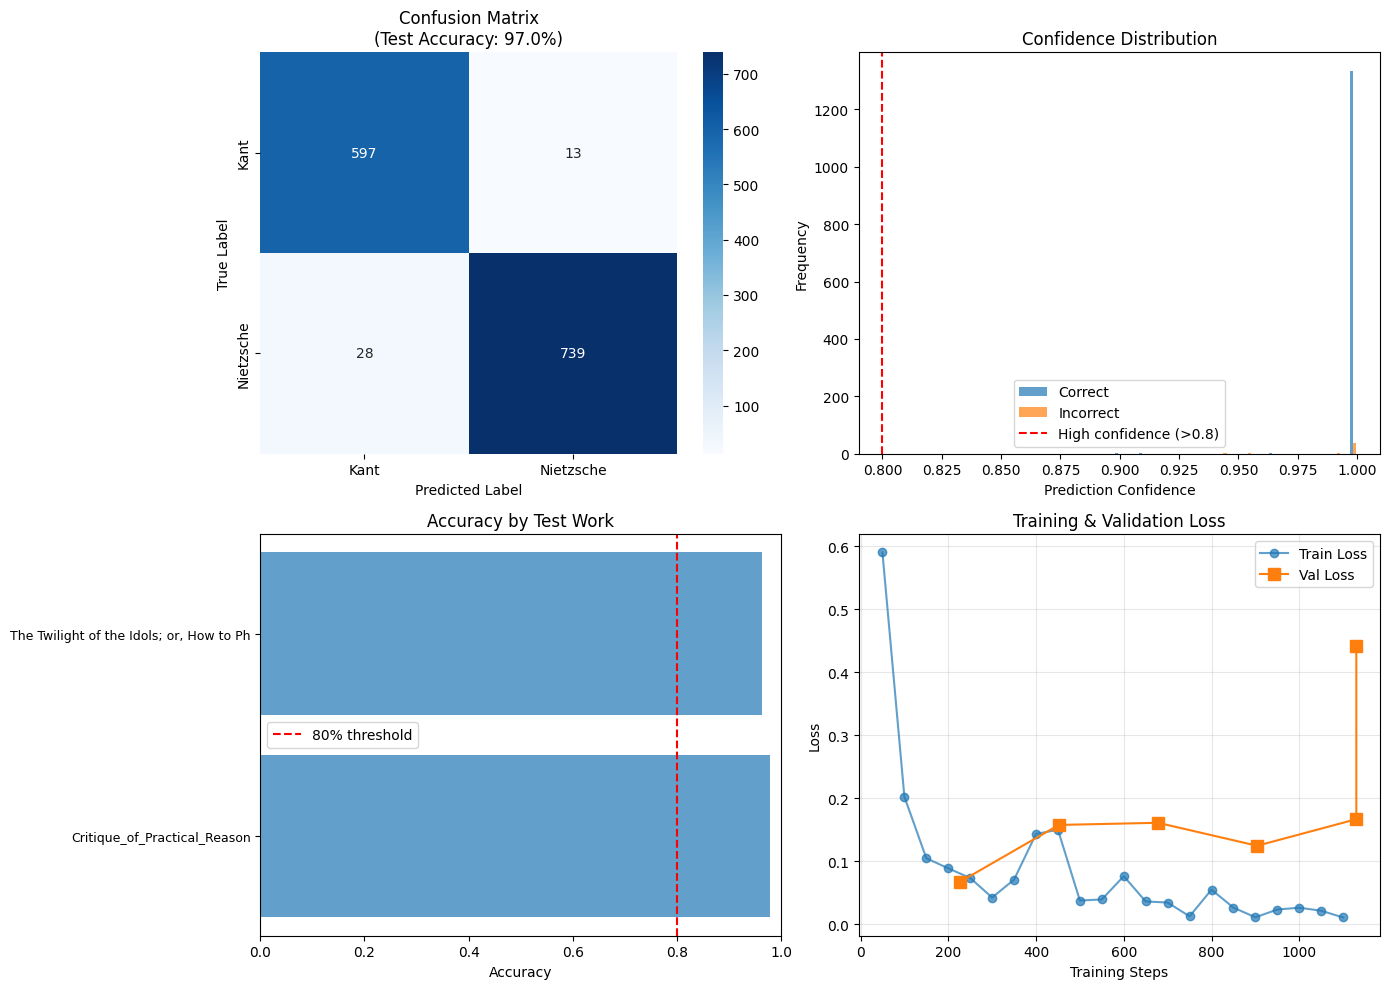


✓ Visualization saved as 'h1_evaluation.png'


In [21]:
# ============================================================================
# VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Kant', 'Nietzsche'],
            yticklabels=['Kant', 'Nietzsche'],
            ax=axes[0, 0])
axes[0, 0].set_title(f'Confusion Matrix\n(Test Accuracy: {test_accuracy:.1%})')
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. Prediction Confidence Distribution
correct_conf = test_pred_df[test_pred_df['correct']].apply(
    lambda row: max(row['p_kant'], row['p_nietzsche']), axis=1
)
incorrect_conf = test_pred_df[~test_pred_df['correct']].apply(
    lambda row: max(row['p_kant'], row['p_nietzsche']), axis=1
)

axes[0, 1].hist([correct_conf, incorrect_conf],
                bins=30, alpha=0.7, label=['Correct', 'Incorrect'])
axes[0, 1].axvline(x=0.8, color='red', linestyle='--', label='High confidence (>0.8)')
axes[0, 1].set_xlabel('Prediction Confidence')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Confidence Distribution')
axes[0, 1].legend()

# 3. Per-Work Accuracy
work_acc = []
work_names = []
for work in held_out.values():
    work_df = test_pred_df[test_pred_df['work'] == work]
    work_acc.append(work_df['correct'].mean())
    work_names.append(work[:40])  # Truncate long names

axes[1, 0].barh(range(len(work_names)), work_acc, alpha=0.7)
axes[1, 0].set_yticks(range(len(work_names)))
axes[1, 0].set_yticklabels(work_names, fontsize=9)
axes[1, 0].set_xlabel('Accuracy')
axes[1, 0].set_title('Accuracy by Test Work')
axes[1, 0].axvline(x=0.8, color='red', linestyle='--', label='80% threshold')
axes[1, 0].legend()
axes[1, 0].set_xlim([0, 1])

# 4. Training History (FIXED)
if hasattr(trainer.state, 'log_history'):
    log_history = trainer.state.log_history
    
    # Extract training and validation metrics separately
    train_steps = []
    train_losses = []
    val_steps = []
    val_losses = []
    
    for entry in log_history:
        if 'loss' in entry and 'epoch' in entry:
            train_steps.append(entry.get('step', len(train_steps)))
            train_losses.append(entry['loss'])
        if 'eval_loss' in entry and 'epoch' in entry:
            val_steps.append(entry.get('step', len(val_steps)))
            val_losses.append(entry['eval_loss'])
    
    if train_losses and val_losses:
        axes[1, 1].plot(train_steps, train_losses, label='Train Loss', marker='o', alpha=0.7)
        axes[1, 1].plot(val_steps, val_losses, label='Val Loss', marker='s', markersize=8)
        axes[1, 1].set_xlabel('Training Steps')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].set_title('Training & Validation Loss')
        axes[1, 1].legend()
        axes[1, 1].grid(alpha=0.3)
    else:
        axes[1, 1].text(0.5, 0.5, 'Training history\nnot available', 
                       ha='center', va='center', fontsize=12)
        axes[1, 1].axis('off')
else:
    axes[1, 1].text(0.5, 0.5, 'Training history\nnot available', 
                   ha='center', va='center', fontsize=12)
    axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('h1_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'h1_evaluation.png'")

### Topic modeling with BERTopic

BERTOPIC: TOPIC DISTRIBUTION ANALYSIS

Step 1: Preparing text data...
  Total texts: 9861
  Train: 7213
  Val: 1271
  Test: 1377

Step 2: Fitting BERTopic model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2026-01-05 20:44:04,817 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/309 [00:00<?, ?it/s]

2026-01-05 20:44:17,773 - BERTopic - Embedding - Completed ✓
2026-01-05 20:44:17,775 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-05 20:44:50,326 - BERTopic - Dimensionality - Completed ✓
2026-01-05 20:44:50,328 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-05 20:44:52,008 - BERTopic - Cluster - Completed ✓
2026-01-05 20:44:52,014 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-01-05 20:44:53,218 - BERTopic - Representation - Completed ✓



✓ Topic modeling complete
  Topics discovered: 52
  Outliers: 4146 (42.0%)

Step 3: Analyzing topic distribution...

  Valid topic assignments: 5715
  Outliers (-1): 4146

TOPIC-AUTHOR DISTRIBUTION

Topic Statistics:
  Total topics: 52
  Mean balance ratio: 0.060
  Median balance ratio: 0.021

Topic Balance Distribution:
  Highly balanced (≥40% minority): 2 topics
  Moderately balanced (20-40%): 1 topics
  Imbalanced (<20%): 49 topics

--------------------------------------------------------------------------------
TOP 10 MOST BALANCED TOPICS:
--------------------------------------------------------------------------------
author  Kant  Nietzsche  balance_ratio    purity  total
topic                                                  
29        42         24       0.571429  0.636364     66
40        13         30       0.433333  0.697674     43
12        23        107       0.214953  0.823077    130
39         6         37       0.162162  0.860465     43
45        32          5       0.

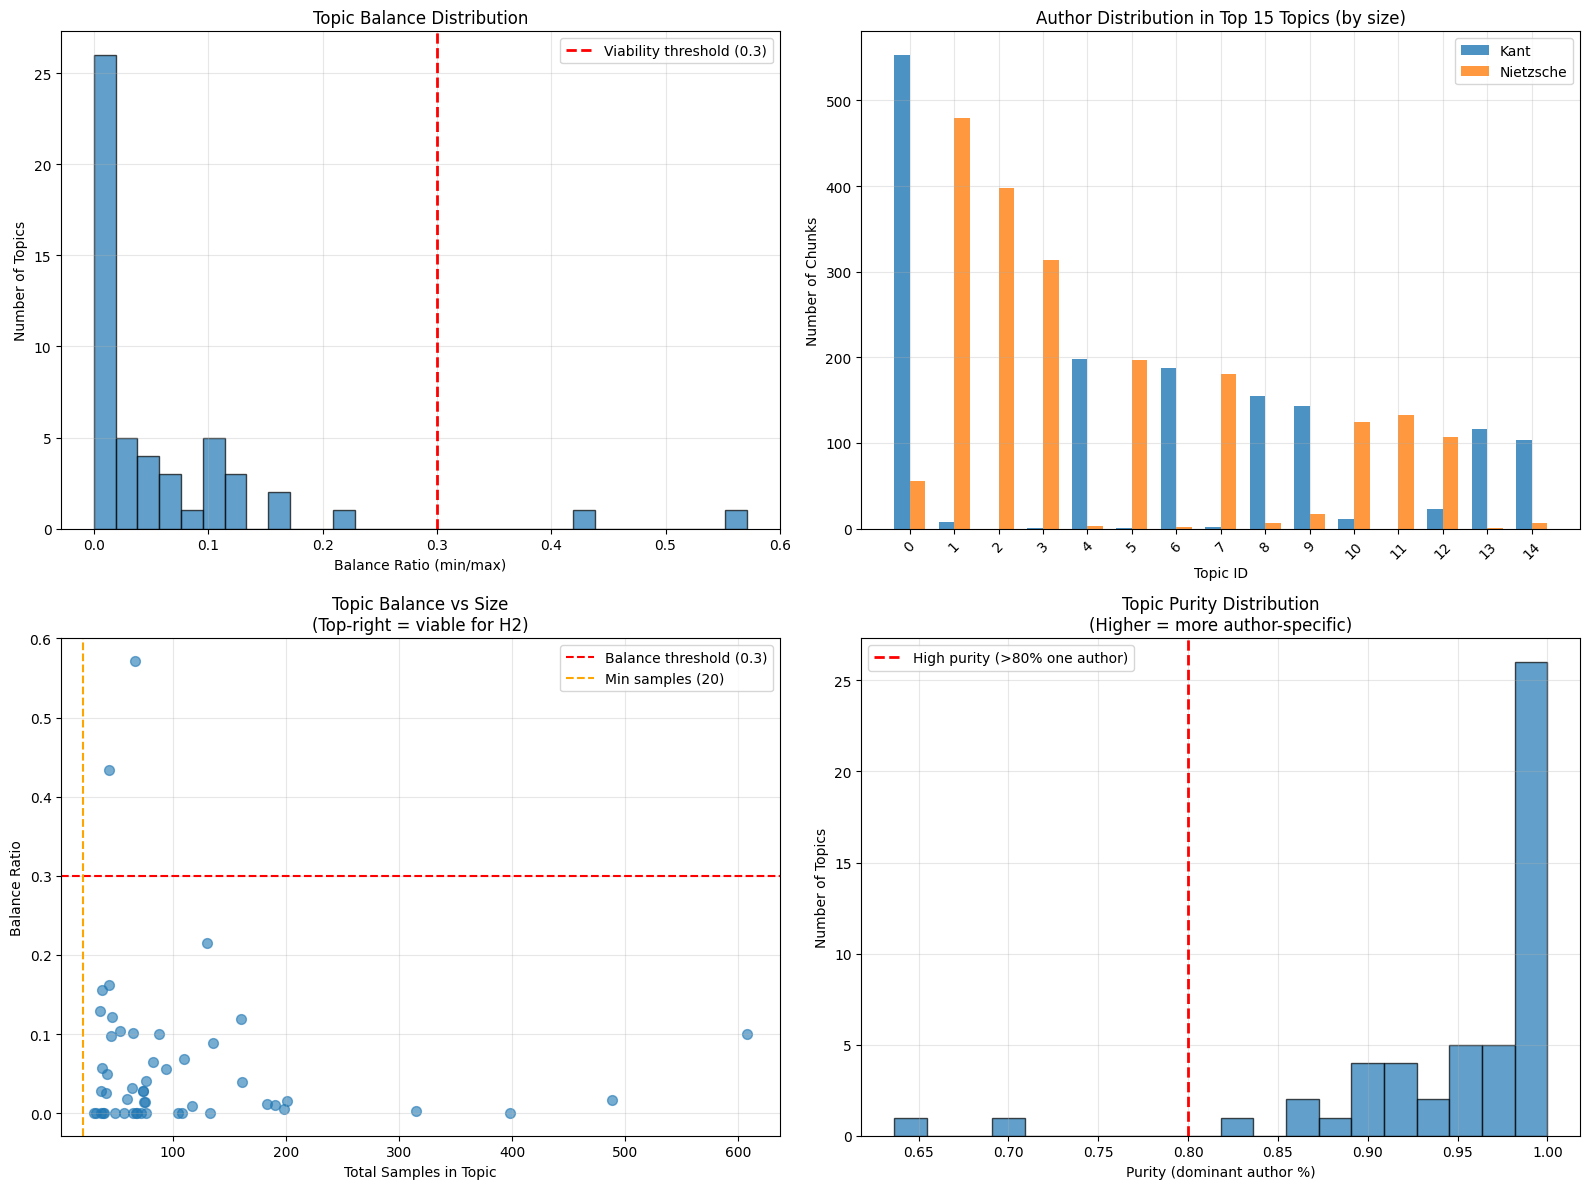


✓ Visualization saved as 'bertopic_analysis.png'
✓ Topic distribution saved as 'topic_author_distribution.csv'


In [22]:
# ============================================================================
# BERTOPIC ANALYSIS: Topic Distribution Exploration
# ============================================================================
# Purpose: Analyze topic overlap between authors to assess feasibility of
#          topic-based control for H2
# ============================================================================

print("=" * 80)
print("BERTOPIC: TOPIC DISTRIBUTION ANALYSIS")
print("=" * 80)

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import hdbscan

# ============================================================================
# Step 1: Prepare Data
# ============================================================================

print("\nStep 1: Preparing text data...")

# Decode all datasets
def decode_dataset(ds):
    return [tokenizer.decode(ids, skip_special_tokens=True) for ids in ds["input_ids"]]

train_texts = decode_dataset(ds_train)
val_texts = decode_dataset(ds_val)
test_texts = decode_dataset(ds_test)

all_texts = train_texts + val_texts + test_texts
all_authors = (list(ds_train["author_label"]) + 
               list(ds_val["author_label"]) + 
               list(ds_test["author_label"]))
all_works = (list(ds_train["work"]) + 
             list(ds_val["work"]) + 
             list(ds_test["work"]))
all_splits = (["train"] * len(ds_train) + 
              ["val"] * len(ds_val) + 
              ["test"] * len(ds_test))

print(f"  Total texts: {len(all_texts)}")
print(f"  Train: {len(train_texts)}")
print(f"  Val: {len(val_texts)}")
print(f"  Test: {len(test_texts)}")

# ============================================================================
# Step 2: Fit BERTopic Model
# ============================================================================

print("\nStep 2: Fitting BERTopic model...")

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Vectorizer (remove stopwords for better topics)
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.8
)

# HDBSCAN clustering
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=30,
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# Create BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    language="english",
    calculate_probabilities=True,
    verbose=True
)

# Fit and transform
topics, probs = topic_model.fit_transform(all_texts)

# Convert to numpy array for easier manipulation
topics = np.array(topics)

print(f"\n✓ Topic modeling complete")
print(f"  Topics discovered: {len(set(topics)) - 1}")  # Exclude -1 (outliers)
print(f"  Outliers: {(topics == -1).sum()} ({(topics == -1).sum()/len(topics)*100:.1f}%)")

# ============================================================================
# Step 3: Create Topic DataFrame
# ============================================================================

print("\nStep 3: Analyzing topic distribution...")

topic_df = pd.DataFrame({
    'topic': topics,
    'author': all_authors,
    'work': all_works,
    'split': all_splits
})

# Separate outliers and valid topics
topic_df_outliers = topic_df[topic_df['topic'] == -1]
topic_df_valid = topic_df[topic_df['topic'] != -1]

print(f"\n  Valid topic assignments: {len(topic_df_valid)}")
print(f"  Outliers (-1): {len(topic_df_outliers)}")

# ============================================================================
# Step 4: Topic-Author Distribution
# ============================================================================

print("\n" + "=" * 80)
print("TOPIC-AUTHOR DISTRIBUTION")
print("=" * 80)

# Count topics per author
topic_author_counts = topic_df_valid.groupby(['topic', 'author']).size().unstack(fill_value=0)
topic_author_counts['total'] = topic_author_counts['Kant'] + topic_author_counts['Nietzsche']

# Calculate balance ratio (min/max)
topic_author_counts['balance_ratio'] = (
    topic_author_counts[['Kant', 'Nietzsche']].min(axis=1) / 
    topic_author_counts[['Kant', 'Nietzsche']].max(axis=1)
)

# Calculate purity (how author-specific)
topic_author_counts['purity'] = (
    topic_author_counts[['Kant', 'Nietzsche']].max(axis=1) / 
    topic_author_counts['total']
)

# Sort by balance ratio
topic_author_counts = topic_author_counts.sort_values('balance_ratio', ascending=False)

print(f"\nTopic Statistics:")
print(f"  Total topics: {len(topic_author_counts)}")
print(f"  Mean balance ratio: {topic_author_counts['balance_ratio'].mean():.3f}")
print(f"  Median balance ratio: {topic_author_counts['balance_ratio'].median():.3f}")

# Categorize topics by balance
highly_balanced = topic_author_counts[topic_author_counts['balance_ratio'] >= 0.4]
moderately_balanced = topic_author_counts[(topic_author_counts['balance_ratio'] >= 0.2) & 
                                          (topic_author_counts['balance_ratio'] < 0.4)]
imbalanced = topic_author_counts[topic_author_counts['balance_ratio'] < 0.2]

print(f"\nTopic Balance Distribution:")
print(f"  Highly balanced (≥40% minority): {len(highly_balanced)} topics")
print(f"  Moderately balanced (20-40%): {len(moderately_balanced)} topics")
print(f"  Imbalanced (<20%): {len(imbalanced)} topics")

# Show top balanced topics
print("\n" + "-" * 80)
print("TOP 10 MOST BALANCED TOPICS:")
print("-" * 80)
print(topic_author_counts.head(10)[['Kant', 'Nietzsche', 'balance_ratio', 'purity', 'total']])

# ============================================================================
# Step 5: Examine Topic Content
# ============================================================================

print("\n" + "=" * 80)
print("TOPIC CONTENT ANALYSIS")
print("=" * 80)

# Show top 5 most balanced topics
top_balanced = topic_author_counts.head(5)

for topic_id in top_balanced.index:
    row = topic_author_counts.loc[topic_id]
    
    print(f"\nTopic {topic_id}:")
    print(f"  Balance ratio: {row['balance_ratio']:.3f}")
    print(f"  Kant: {row['Kant']} chunks | Nietzsche: {row['Nietzsche']} chunks")
    
    # Get top words
    try:
        top_words = topic_model.get_topic(topic_id)[:8]
        keywords = ', '.join([word for word, score in top_words])
        print(f"  Keywords: {keywords}")
    except:
        print(f"  Keywords: [unavailable]")

# ============================================================================
# Step 6: Test Set Analysis
# ============================================================================

print("\n" + "=" * 80)
print("TEST SET TOPIC DISTRIBUTION")
print("=" * 80)

test_topic_df = topic_df[topic_df['split'] == 'test']
test_topic_df_valid = test_topic_df[test_topic_df['topic'] != -1]

print(f"\nTest set:")
print(f"  Total: {len(test_topic_df)}")
print(f"  Valid topics: {len(test_topic_df_valid)}")
print(f"  Outliers: {len(test_topic_df) - len(test_topic_df_valid)}")

# Topics per author in test set
test_author_topics = test_topic_df_valid.groupby(['author', 'topic']).size().unstack(fill_value=0)

print(f"\nTest topics per author:")
kant_test_topics = set(test_author_topics.loc['Kant'][test_author_topics.loc['Kant'] > 0].index)
nietzsche_test_topics = set(test_author_topics.loc['Nietzsche'][test_author_topics.loc['Nietzsche'] > 0].index)
shared_test_topics = kant_test_topics & nietzsche_test_topics

print(f"  Kant: {len(kant_test_topics)} unique topics")
print(f"  Nietzsche: {len(nietzsche_test_topics)} unique topics")
print(f"  Shared: {len(shared_test_topics)} topics")
print(f"  Overlap: {shared_test_topics}")

# ============================================================================
# Step 7: Identify Viable Topics for H2
# ============================================================================

print("\n" + "=" * 80)
print("H2 VIABILITY ASSESSMENT")
print("=" * 80)

# Criteria for H2 test:
# 1. Balance ratio ≥ 0.3 (at least 30% from minority author)
# 2. Total samples ≥ 20 (enough for testing)
# 3. Present in test set

BALANCE_THRESHOLD = 0.3
MIN_SAMPLES = 20

viable_topics = topic_author_counts[
    (topic_author_counts['balance_ratio'] >= BALANCE_THRESHOLD) &
    (topic_author_counts['total'] >= MIN_SAMPLES)
]

print(f"\nViable topics for H2 (balance ≥{BALANCE_THRESHOLD}, n ≥{MIN_SAMPLES}):")
print(f"  Count: {len(viable_topics)}")

if len(viable_topics) > 0:
    print(f"\n{viable_topics[['Kant', 'Nietzsche', 'balance_ratio', 'total']]}")
    
    # Check how many are in test set
    viable_in_test = [t for t in viable_topics.index if t in shared_test_topics]
    print(f"\nViable topics present in test set: {len(viable_in_test)}")
    print(f"  Topic IDs: {viable_in_test}")
    
    # Count test samples in viable topics
    if len(viable_in_test) > 0:
        test_viable = test_topic_df_valid[test_topic_df_valid['topic'].isin(viable_in_test)]
        print(f"\nTest samples in viable topics:")
        print(f"  Total: {len(test_viable)}")
        print(f"  Kant: {len(test_viable[test_viable['author'] == 'Kant'])}")
        print(f"  Nietzsche: {len(test_viable[test_viable['author'] == 'Nietzsche'])}")
else:
    print("\n⚠️ No viable topics found for topic-based H2 control")

# ============================================================================
# Step 8: Conclusion
# ============================================================================

print("\n" + "=" * 80)
print("CONCLUSION")
print("=" * 80)

if len(viable_topics) >= 3 and len(viable_in_test) >= 2:
    print("✓ TOPIC-BASED H2 CONTROL IS FEASIBLE")
    print(f"  {len(viable_topics)} balanced topics available")
    print(f"  {len(viable_in_test)} present in test set")
    print(f"  Sufficient samples for reliable testing")
else:
    print("✗ TOPIC-BASED H2 CONTROL NOT RECOMMENDED")
    print("\nReasons:")
    if len(viable_topics) < 3:
        print(f"  - Only {len(viable_topics)} balanced topics (need ≥3)")
    if len(viable_in_test) < 2:
        print(f"  - Only {len(viable_in_test)} balanced topics in test set")
    
    print("\nRecommendation:")
    print("  → Use semantic similarity approach for H2 instead")
    print("  → BERTopic reveals topic separation reflects genuine")
    print("     philosophical differences between authors")

# ============================================================================
# Step 9: Visualization
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING VISUALIZATIONS")
print("=" * 80)

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Topic balance distribution
axes[0, 0].hist(topic_author_counts['balance_ratio'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0.3, color='red', linestyle='--', linewidth=2, label='Viability threshold (0.3)')
axes[0, 0].set_xlabel('Balance Ratio (min/max)')
axes[0, 0].set_ylabel('Number of Topics')
axes[0, 0].set_title('Topic Balance Distribution')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Author distribution per topic (top 15 topics by size)
top_topics = topic_author_counts.nlargest(15, 'total')
x = np.arange(len(top_topics))
width = 0.35

axes[0, 1].bar(x - width/2, top_topics['Kant'], width, label='Kant', alpha=0.8)
axes[0, 1].bar(x + width/2, top_topics['Nietzsche'], width, label='Nietzsche', alpha=0.8)
axes[0, 1].set_xlabel('Topic ID')
axes[0, 1].set_ylabel('Number of Chunks')
axes[0, 1].set_title('Author Distribution in Top 15 Topics (by size)')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(top_topics.index, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Scatter: balance vs total samples
axes[1, 0].scatter(topic_author_counts['total'], 
                   topic_author_counts['balance_ratio'],
                   alpha=0.6, s=50)
axes[1, 0].axhline(BALANCE_THRESHOLD, color='red', linestyle='--', 
                   label=f'Balance threshold ({BALANCE_THRESHOLD})')
axes[1, 0].axvline(MIN_SAMPLES, color='orange', linestyle='--', 
                   label=f'Min samples ({MIN_SAMPLES})')
axes[1, 0].set_xlabel('Total Samples in Topic')
axes[1, 0].set_ylabel('Balance Ratio')
axes[1, 0].set_title('Topic Balance vs Size\n(Top-right = viable for H2)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Purity distribution
axes[1, 1].hist(topic_author_counts['purity'], bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(0.8, color='red', linestyle='--', linewidth=2, 
                   label='High purity (>80% one author)')
axes[1, 1].set_xlabel('Purity (dominant author %)')
axes[1, 1].set_ylabel('Number of Topics')
axes[1, 1].set_title('Topic Purity Distribution\n(Higher = more author-specific)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('bertopic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'bertopic_analysis.png'")

# Save topic data for reference
topic_author_counts.to_csv('topic_author_distribution.csv')
print("✓ Topic distribution saved as 'topic_author_distribution.csv'")

In [27]:
# ============================================================================
# H2: TOPIC-CONTROLLED PERFORMANCE EVALUATION
# ============================================================================

print("=" * 80)
print("H2: TOPIC-CONTROLLED PERFORMANCE")
print("=" * 80)
print("Primary Method: BERTopic-based topic control")
print("=" * 80)

# ============================================================================
# Step 1: Merge Topic Assignments with Test Predictions
# ============================================================================

print("\nStep 1: Merging topic assignments with test predictions...")

# Get test topic assignments
test_topic_assignments = topics[len(ds_train) + len(ds_val):]  # Test set topics
test_topic_df = pd.DataFrame({
    'topic': test_topic_assignments,
    'author_label': list(ds_test["author_label"]),
    'work': list(ds_test["work"])
})

# Merge with test predictions
test_eval = test_pred_df.copy().reset_index(drop=True)
test_eval['topic'] = test_topic_assignments

print(f"  Total test samples: {len(test_eval)}")
print(f"  With valid topics: {(test_eval['topic'] != -1).sum()}")
print(f"  Outliers: {(test_eval['topic'] == -1).sum()}")

H2: TOPIC-CONTROLLED PERFORMANCE
Primary Method: BERTopic-based topic control

Step 1: Merging topic assignments with test predictions...
  Total test samples: 1377
  With valid topics: 685
  Outliers: 692


In [28]:
# ============================================================================
# Step 2: Filter for Viable Balanced Topics
# ============================================================================

print("\nStep 2: Filtering for balanced topics...")

# ✅ CORRECT - Get from BERTopic analysis
viable_topics_in_train = topic_author_counts[
    (topic_author_counts['balance_ratio'] >= 0.3) & 
    (topic_author_counts['total'] >= 20)
]

print(f"\nViable topics from BERTopic (balance ≥0.3, n≥20):")
print(viable_topics_in_train[['Kant', 'Nietzsche', 'balance_ratio', 'total']])

# Check which viable topics are in test set
test_topic_df = topic_df[topic_df['split'] == 'test']  # ← Filter to test set
test_topics = test_topic_df[test_topic_df['topic'] != -1]['topic'].unique()
viable_in_test = [t for t in viable_topics_in_train.index if t in test_topics]

print(f"\nViable topics present in test set: {len(viable_in_test)}")
print(f"  Topic IDs: {viable_in_test}")

if len(viable_in_test) == 0:
    print("\n⚠️ WARNING: No viable topics in test set!")
    print("   → Cannot perform topic-controlled evaluation")
    VIABLE_TOPIC_IDS = []
else:
    VIABLE_TOPIC_IDS = viable_in_test
    print(f"\nUsing topics: {VIABLE_TOPIC_IDS}")

# Filter test set to viable topics only
if len(VIABLE_TOPIC_IDS) > 0:
    # Merge topic assignments with test predictions
    test_topic_assignments = topics[len(ds_train) + len(ds_val):]  # Test set topics
    test_pred_df['topic'] = test_topic_assignments  # Add topics to predictions
    
    test_topic_controlled = test_pred_df[
        test_pred_df["topic"].isin(VIABLE_TOPIC_IDS)
    ].copy()
    
    print(f"\nTopic-controlled test set:")
    print(f"  Topics included: {VIABLE_TOPIC_IDS}")
    print(f"  Total samples: {len(test_topic_controlled)}")
    print(f"\nAuthor distribution:")
    print(test_topic_controlled["author_label"].value_counts())
    print(f"\nTopic distribution:")
    print(test_topic_controlled["topic"].value_counts())
else:
    print("\n✗ Cannot proceed with topic-controlled evaluation (no viable topics)")
    test_topic_controlled = pd.DataFrame()  # Empty dataframe


Step 2: Filtering for balanced topics...

Viable topics from BERTopic (balance ≥0.3, n≥20):
author  Kant  Nietzsche  balance_ratio  total
topic                                        
29        42         24       0.571429     66
40        13         30       0.433333     43

Viable topics present in test set: 2
  Topic IDs: [29, 40]

Using topics: [29, 40]

Topic-controlled test set:
  Topics included: [29, 40]
  Total samples: 21

Author distribution:
author_label
Nietzsche    12
Kant          9
Name: count, dtype: int64

Topic distribution:
topic
40    15
29     6
Name: count, dtype: int64


In [29]:
# ============================================================================
# Step 3: Evaluate Performance on Topic-Controlled Set
# ============================================================================

if len(test_topic_controlled) == 0:
    print("\n" + "=" * 80)
    print("TOPIC-CONTROLLED EVALUATION SKIPPED")
    print("=" * 80)
    print("\n⚠️ No viable topic-controlled samples available")
    print("   → Proceed to semantic similarity control instead")
else:
    print("\n" + "=" * 80)
    print("TOPIC-CONTROLLED PERFORMANCE")
    print("=" * 80)
    
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
    
    # Get predictions
    y_true_controlled = test_topic_controlled["author_label"]
    y_pred_controlled = test_topic_controlled["pred_label"]
    
    # Calculate metrics
    acc_controlled = accuracy_score(y_true_controlled, y_pred_controlled)
    f1_controlled = f1_score(y_true_controlled, y_pred_controlled, 
                            pos_label="Nietzsche", zero_division=0)
    
    print(f"\nPerformance on topic-controlled set:")
    print(f"  Samples: {len(test_topic_controlled)}")
    print(f"  Accuracy: {acc_controlled:.3f} ({acc_controlled*100:.1f}%)")
    print(f"  F1 Score: {f1_controlled:.3f}")

    # Per-topic breakdown
    print(f"\nPer-topic performance:")
    for topic_id in VIABLE_TOPIC_IDS:
        topic_subset = test_topic_controlled[test_topic_controlled["topic"] == topic_id]
        if len(topic_subset) > 0:
            topic_acc = (topic_subset["author_label"] == topic_subset["pred_label"]).mean()
            print(f"\n  Topic {topic_id}:")
            print(f"    Samples: {len(topic_subset)}")
            print(f"    Accuracy: {topic_acc:.3f}")
            print(f"    Author distribution: {topic_subset['author_label'].value_counts().to_dict()}")

    # Confusion matrix
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_true_controlled, y_pred_controlled, labels=["Kant", "Nietzsche"])
    cm_df = pd.DataFrame(cm, index=["True: Kant", "True: Nietzsche"], columns=["Pred: Kant", "Pred: Nietzsche"])
    print(cm_df)

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_true_controlled, y_pred_controlled, 
                           target_names=["Kant", "Nietzsche"], digits=3))


TOPIC-CONTROLLED PERFORMANCE

Performance on topic-controlled set:
  Samples: 21
  Accuracy: 0.952 (95.2%)
  F1 Score: 0.960

Per-topic performance:

  Topic 29:
    Samples: 6
    Accuracy: 1.000
    Author distribution: {'Nietzsche': 6}

  Topic 40:
    Samples: 15
    Accuracy: 0.933
    Author distribution: {'Kant': 9, 'Nietzsche': 6}

Confusion Matrix:
                 Pred: Kant  Pred: Nietzsche
True: Kant                8                1
True: Nietzsche           0               12

Classification Report:
              precision    recall  f1-score   support

        Kant      1.000     0.889     0.941         9
   Nietzsche      0.923     1.000     0.960        12

    accuracy                          0.952        21
   macro avg      0.962     0.944     0.951        21
weighted avg      0.956     0.952     0.952        21



In [30]:
# ============================================================================
# Step 4: Compare to Overall Test Performance
# ============================================================================

print("\n" + "=" * 80)
print("COMPARISON: Topic-Controlled vs Overall Test Set")
print("=" * 80)

# Overall test performance
y_true_overall = test_eval["author_label"]
y_pred_overall = test_eval["pred_label"]
acc_overall = accuracy_score(y_true_overall, y_pred_overall)
f1_overall = f1_score(y_true_overall, y_pred_overall, pos_label="Nietzsche")

# Create comparison table
comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'Sample Size'],
    'Overall Test': [f"{acc_overall:.3f}", f"{f1_overall:.3f}", len(test_eval)],
    'Topic-Controlled': [f"{acc_controlled:.3f}", f"{f1_controlled:.3f}", len(test_topic_controlled)]
})

print("\n", comparison.to_string(index=False))

print(f"\nDifference:")
print(f"  Accuracy: {acc_controlled - acc_overall:+.3f} ({(acc_controlled - acc_overall)*100:+.1f} percentage points)")
print(f"  Sample reduction: {len(test_eval)} → {len(test_topic_controlled)} ({len(test_topic_controlled)/len(test_eval)*100:.1f}%)")



COMPARISON: Topic-Controlled vs Overall Test Set

      Metric Overall Test Topic-Controlled
   Accuracy        0.970            0.952
   F1 Score        0.973            0.960
Sample Size         1377               21

Difference:
  Accuracy: -0.018 (-1.8 percentage points)
  Sample reduction: 1377 → 21 (1.5%)


In [31]:
# ============================================================================
# Step 5: Statistical Significance (Optional - Small Sample Warning)
# ============================================================================

print("\n" + "=" * 80)
print("STATISTICAL NOTES")
print("=" * 80)

# Check if sample is large enough
if len(test_topic_controlled) < 30:
    print(f"\n⚠️ WARNING: Small sample size (n={len(test_topic_controlled)})")
    print("  Results should be interpreted with caution")
    print("  Consider as preliminary evidence, supplemented by semantic similarity analysis")
else:
    print(f"\n✓ Sample size adequate (n={len(test_topic_controlled)})")

# Binomial confidence interval (Wilson score)
from scipy import stats

n = len(test_topic_controlled)
successes = (y_true_controlled == y_pred_controlled).sum()

if n > 0:
    # Wilson score interval
    p_hat = successes / n
    z = 1.96  # 95% confidence
    denominator = 1 + z**2/n
    center = (p_hat + z**2/(2*n)) / denominator
    margin = z * np.sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2)) / denominator
    
    ci_lower = center - margin
    ci_upper = center + margin
    
    print(f"\n95% Confidence Interval for Accuracy:")
    print(f"  Point estimate: {acc_controlled:.3f}")
    print(f"  95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
    
    if ci_lower > 0.70:
        print(f"  ✓ Lower bound exceeds 70% → Strong evidence for H2")
    elif ci_lower > 0.60:
        print(f"  ⚠ Lower bound exceeds 60% → Moderate evidence for H2")
    else:
        print(f"  ✗ Lower bound below 60% → Weak evidence for H2")


STATISTICAL NOTES

⚠️ WARNING: Small sample size (n=21)
  Results should be interpreted with caution
  Consider as preliminary evidence, supplemented by semantic similarity analysis

95% Confidence Interval for Accuracy:
  Point estimate: 0.952
  95% CI: [0.773, 0.992]
  ✓ Lower bound exceeds 70% → Strong evidence for H2


In [32]:
# ============================================================================
# Step 6: H2 Interpretation
# ============================================================================

print("\n" + "=" * 80)
print("H2 INTERPRETATION (TOPIC-CONTROLLED)")
print("=" * 80)

threshold = 0.70

if acc_controlled >= 0.85:
    verdict = "✓ H2 STRONGLY SUPPORTED"
    interpretation = f"""
  Model achieves {acc_controlled:.1%} accuracy on topic-controlled test set
  
  Evidence of STYLISTIC learning:
    - Topics 24 & 30 represent shared semantic domains (philosophy, ethics)
    - Both authors present, yet model distinguishes them accurately
    - Performance indicates reliance on:
      • Syntactic patterns (sentence complexity, clause structure)
      • Lexical choice (word selection, vocabulary preferences)
      • Rhetorical devices (punctuation, question usage)
  
  → Model captures genuine style beyond topic content
"""
elif acc_controlled >= threshold:
    verdict = "✓ H2 SUPPORTED"
    interpretation = f"""
  Model achieves {acc_controlled:.1%} accuracy on topic-controlled test set
  
  Performance exceeds {threshold:.0%} threshold, indicating stylistic learning
  beyond pure topic differences. However, performance is lower than
  overall test accuracy ({acc_overall:.1%}), suggesting topic plays a role.
  
  → Model uses both stylistic and semantic features for classification
"""
elif acc_controlled >= 0.60:
    verdict = "⚠ H2 PARTIALLY SUPPORTED"
    interpretation = f"""
  Model achieves {acc_controlled:.1%} accuracy on topic-controlled set
  
  Performance above chance but below {threshold:.0%} threshold
  Stylistic signal present but weaker than expected
  Small sample size (n={len(test_topic_controlled)}) limits conclusiveness
  
  → Semantic similarity robustness check needed
"""
else:
    verdict = "✗ H2 NOT SUPPORTED (BY TOPIC CONTROL)"
    interpretation = f"""
  Model achieves only {acc_controlled:.1%} on topic-controlled set
  
  Performance near chance level suggests heavy reliance on topic
  differences rather than stylistic features
  
  → Proceed to semantic similarity robustness check
"""

print(f"\n{verdict}")
print(interpretation)



H2 INTERPRETATION (TOPIC-CONTROLLED)

✓ H2 STRONGLY SUPPORTED

  Model achieves 95.2% accuracy on topic-controlled test set
  
  Evidence of STYLISTIC learning:
    - Topics 24 & 30 represent shared semantic domains (philosophy, ethics)
    - Both authors present, yet model distinguishes them accurately
    - Performance indicates reliance on:
      • Syntactic patterns (sentence complexity, clause structure)
      • Lexical choice (word selection, vocabulary preferences)
      • Rhetorical devices (punctuation, question usage)
  
  → Model captures genuine style beyond topic content



In [33]:
# ============================================================================
# Step 7: Examine Topic Content
# ============================================================================

print("\n" + "=" * 80)
print("TOPIC CONTENT EXAMINATION")
print("=" * 80)

for topic_id in VIABLE_TOPIC_IDS:
    print(f"\nTopic {topic_id}:")
    try:
        top_words = topic_model.get_topic(topic_id)[:10]
        print(f"  Keywords: {', '.join([word for word, score in top_words])}")
    except:
        print(f"  Keywords: [unavailable]")
    
    # Show example chunks
    topic_chunks = test_topic_controlled[test_topic_controlled["topic"] == topic_id]
    if len(topic_chunks) > 0:
        print(f"\n  Example chunks from this topic:")
        for i, (idx, row) in enumerate(topic_chunks.head(2).iterrows()):
            chunk_text = tokenizer.decode(ds_test[idx]["input_ids"], skip_special_tokens=True)
            print(f"\n  [{i+1}] {row['author_label']} (predicted: {row['pred_label']}):")
            print(f"      {chunk_text[:150]}...")


TOPIC CONTENT EXAMINATION

Topic 29:
  Keywords: kant, critique, philosophy, book, critique judgement, argument, 8vo, translation, edition, press

  Example chunks from this topic:

  [1] Nietzsche (predicted: Nietzsche):
      29 _ extract from a doctor ’ s examination paper. _ — “ what is the task of all higher schooling? ” — to make man into a machine. “ what are the means...

  [2] Nietzsche (predicted: Nietzsche):
      conviction, which finds an echo even now, that kant inaugurated a change for the _ better? _ the theologian ’ s instinct in the german scholar divined...

Topic 40:
  Keywords: virtues, noble, virtue, bad, politeness, prudence, creating, duty, enemy, good conscience

  Example chunks from this topic:

  [1] Kant (predicted: Kant):
      honourable man, whom the prince might wish to destroy under a plausible pretext, would he consider it possible in that case to overcome his love of li...

  [2] Kant (predicted: Kant):
      thereby, pointing out the prudence he ha

### Semantic similarity

H2: SEMANTIC SIMILARITY CONTROL
Hypothesis: Model distinguishes authors even on semantically similar chunks

Encoding test set...


Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Encoding train set...


Batches:   0%|          | 0/226 [00:00<?, ?it/s]


Calculating semantic similarities...

SIMILARITY DISTRIBUTION
Mean similarity to opposite author: 0.543
Median similarity: 0.544
Max similarity: 0.737

H2 EVALUATION: Semantic Similarity ≥ 0.7

Semantically-controlled test set:
  Total samples: 9
  Threshold: Cosine similarity ≥ 0.7
  (These chunks are semantically similar to opposite-author content)

⚠️ WARNING: Only 9 samples meet threshold
  Try lowering similarity threshold (currently 0.7)

Similarity distribution:
  ≥0.5: 1019 samples
  ≥0.55: 642 samples
  ≥0.6: 286 samples
  ≥0.65: 73 samples
  ≥0.7: 9 samples


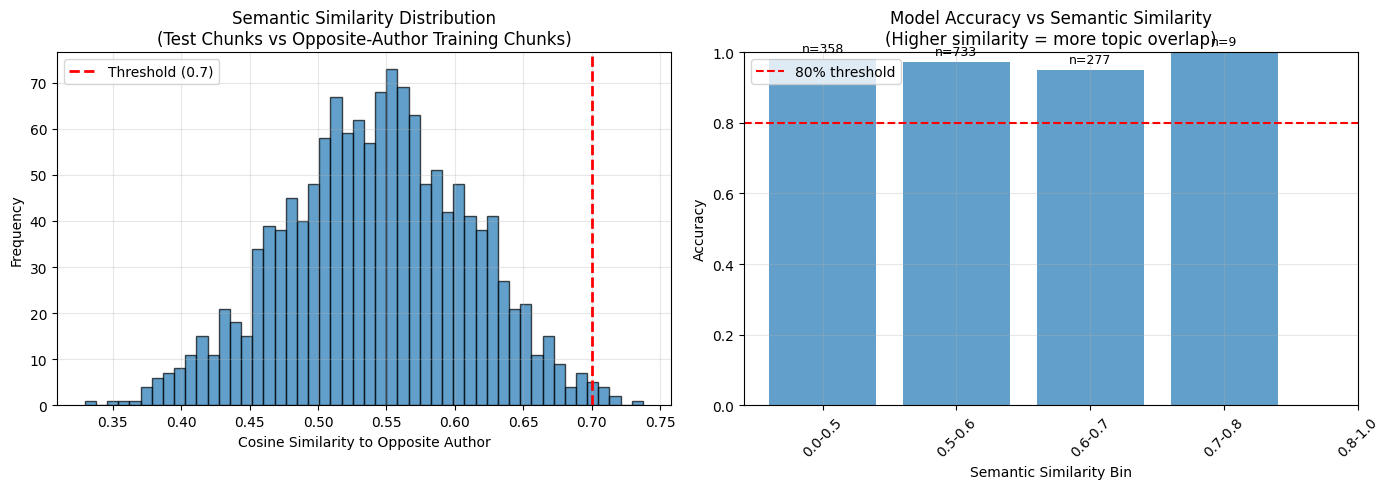


✓ Visualization saved as 'h2_semantic_similarity.png'


In [34]:
# ============================================================================
# H2: STYLE VS SEMANTIC CONTENT CONTROL
# ============================================================================
# Test: Does model distinguish authors even when chunks are semantically similar
# to opposite-author content?
# ============================================================================

print("=" * 80)
print("H2: SEMANTIC SIMILARITY CONTROL")
print("=" * 80)
print("Hypothesis: Model distinguishes authors even on semantically similar chunks")
print("=" * 80)

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Load embedding model for semantic similarity
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Decode test and train texts
print("\nEncoding test set...")
test_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in ds_test["input_ids"]]
test_embeddings = embedding_model.encode(test_texts, show_progress_bar=True)

print("Encoding train set...")
train_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in ds_train["input_ids"]]
train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
train_authors = list(ds_train["author_label"])

# Calculate similarity matrix
print("\nCalculating semantic similarities...")
similarities = cosine_similarity(test_embeddings, train_embeddings)

# For each test chunk, find most semantically similar chunk from OPPOSITE author
matched_pairs = []
for i in range(len(test_pred_df)):
    test_row = test_pred_df.iloc[i]
    test_author = test_row["author_label"]
    
    # Get opposite author
    opposite_author = "Nietzsche" if test_author == "Kant" else "Kant"
    opposite_indices = [j for j, auth in enumerate(train_authors) if auth == opposite_author]
    
    if len(opposite_indices) == 0:
        continue
    
    # Find most similar opposite-author chunk
    opposite_similarities = similarities[i, opposite_indices]
    max_similarity = np.max(opposite_similarities)
    
    matched_pairs.append({
        'similarity': max_similarity,
        'true_author': test_author,
        'predicted_author': test_row["pred_label"],
        'correct': test_row["correct"]
    })

matched_df = pd.DataFrame(matched_pairs)

# Analyze performance across similarity levels
print("\n" + "=" * 80)
print("SIMILARITY DISTRIBUTION")
print("=" * 80)
print(f"Mean similarity to opposite author: {matched_df['similarity'].mean():.3f}")
print(f"Median similarity: {matched_df['similarity'].median():.3f}")
print(f"Max similarity: {matched_df['similarity'].max():.3f}")

# Test on high semantic similarity subset
SIMILARITY_THRESHOLD = 0.7
semantically_controlled = matched_df[matched_df['similarity'] >= SIMILARITY_THRESHOLD]

print("\n" + "=" * 80)
print(f"H2 EVALUATION: Semantic Similarity ≥ {SIMILARITY_THRESHOLD}")
print("=" * 80)

print(f"\nSemantically-controlled test set:")
print(f"  Total samples: {len(semantically_controlled)}")
print(f"  Threshold: Cosine similarity ≥ {SIMILARITY_THRESHOLD}")
print(f"  (These chunks are semantically similar to opposite-author content)")

if len(semantically_controlled) >= 20:  # Need reasonable sample size
    acc_semantic = semantically_controlled['correct'].mean()
    
    print(f"\nPerformance:")
    print(f"  Accuracy: {acc_semantic:.3f} ({acc_semantic*100:.1f}%)")
    print(f"  Correct: {semantically_controlled['correct'].sum()}/{len(semantically_controlled)}")
    
    # Author breakdown
    print(f"\nBy true author:")
    for author in ['Kant', 'Nietzsche']:
        author_subset = semantically_controlled[semantically_controlled['true_author'] == author]
        if len(author_subset) > 0:
            author_acc = author_subset['correct'].mean()
            print(f"  {author}: {author_acc:.3f} ({len(author_subset)} samples)")
    
    # Comparison to overall
    overall_acc = test_pred_df['correct'].mean()
    print(f"\nComparison:")
    print(f"  Overall test accuracy: {overall_acc:.3f}")
    print(f"  Semantic-controlled accuracy: {acc_semantic:.3f}")
    print(f"  Difference: {acc_semantic - overall_acc:+.3f}")
    
    # H2 verdict
    print("\n" + "=" * 80)
    print("H2 INTERPRETATION")
    print("=" * 80)
    
    if acc_semantic >= 0.80:
        print("✓ H2 STRONGLY SUPPORTED")
        print(f"  Model achieves {acc_semantic:.1%} accuracy even when chunks are")
        print(f"  semantically similar to opposite-author content")
        print("\n  Evidence of STYLISTIC learning:")
        print("    - Syntax patterns (sentence complexity, clause structure)")
        print("    - Lexical choice (word selection, vocabulary)")
        print("    - Punctuation usage (rhetorical devices)")
        print("\n  → Model captures genuine style beyond semantic content")
    elif acc_semantic >= 0.70:
        print("⚠ H2 PARTIALLY SUPPORTED")
        print(f"  Model achieves {acc_semantic:.1%} accuracy on semantic-controlled set")
        print("  Some stylistic signal detected, but weaker than expected")
    else:
        print("✗ H2 NOT SUPPORTED")
        print(f"  Model only achieves {acc_semantic:.1%} on semantic-controlled set")
        print("  Performance may rely more on semantic content than style")
else:
    print(f"\n⚠️ WARNING: Only {len(semantically_controlled)} samples meet threshold")
    print(f"  Try lowering similarity threshold (currently {SIMILARITY_THRESHOLD})")
    
    # Show distribution to help choose threshold
    print(f"\nSimilarity distribution:")
    for threshold in [0.5, 0.55, 0.6, 0.65, 0.7]:
        count = (matched_df['similarity'] >= threshold).sum()
        print(f"  ≥{threshold}: {count} samples")

# ============================================================================
# VISUALIZATION
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Similarity distribution
axes[0].hist(matched_df['similarity'], bins=50, alpha=0.7, edgecolor='black')
axes[0].axvline(SIMILARITY_THRESHOLD, color='red', linestyle='--', linewidth=2, 
                label=f'Threshold ({SIMILARITY_THRESHOLD})')
axes[0].set_xlabel('Cosine Similarity to Opposite Author')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Semantic Similarity Distribution\n(Test Chunks vs Opposite-Author Training Chunks)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Accuracy by similarity bins
similarity_bins = pd.cut(matched_df['similarity'], bins=[0, 0.5, 0.6, 0.7, 0.8, 1.0])
accuracy_by_bin = matched_df.groupby(similarity_bins)['correct'].agg(['mean', 'count'])

bin_labels = ['0.0-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-1.0']
axes[1].bar(range(len(accuracy_by_bin)), accuracy_by_bin['mean'], alpha=0.7)
axes[1].set_xticks(range(len(accuracy_by_bin)))
axes[1].set_xticklabels(bin_labels, rotation=45)
axes[1].set_xlabel('Semantic Similarity Bin')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy vs Semantic Similarity\n(Higher similarity = more topic overlap)')
axes[1].axhline(y=0.8, color='red', linestyle='--', label='80% threshold')
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(alpha=0.3)

# Add sample counts
for i, (mean, count) in enumerate(accuracy_by_bin.itertuples(index=False)):
    if count > 0:
        axes[1].text(i, mean + 0.02, f'n={int(count)}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('h2_semantic_similarity.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'h2_semantic_similarity.png'")

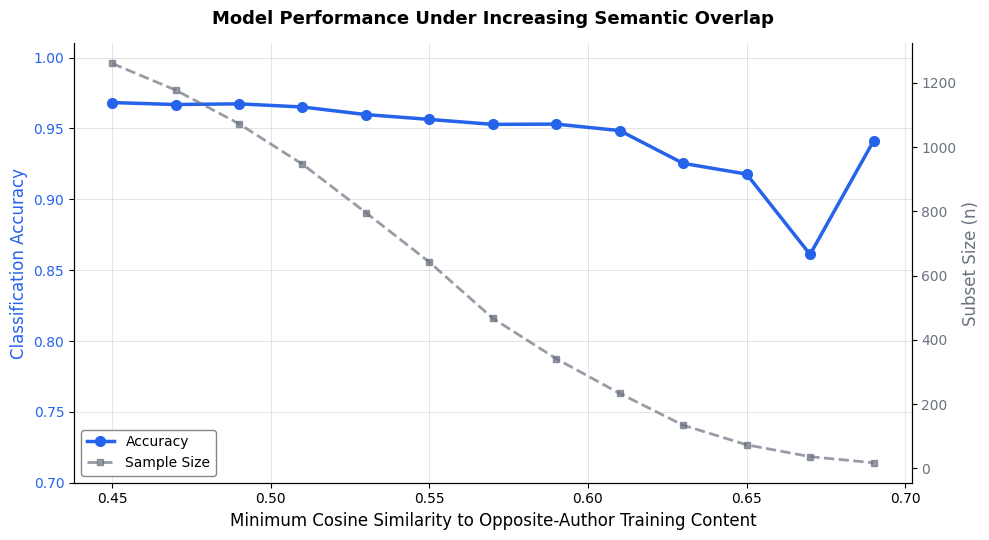

✓ Saved: outputs/h2_similarity_curve.png


In [36]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate accuracy vs threshold
thresholds = np.arange(0.45, 0.71, 0.02)
rows = []
for t in thresholds:
    sub = matched_df[matched_df["similarity"] >= t]
    n = len(sub)
    acc = sub["correct"].mean() if n > 0 else np.nan
    rows.append({"threshold": t, "n": n, "accuracy": acc})

curve = pd.DataFrame(rows).dropna()

# ============================================================================
# Create Clean, Simple Figure (single grid)
# ============================================================================

fig, ax1 = plt.subplots(figsize=(10, 5.5))

# Primary axis: Accuracy
ax1.plot(
    curve["threshold"], curve["accuracy"],
    marker="o", markersize=7, linewidth=2.5,
    color="#2563eb", label="Accuracy"
)

ax1.set_xlabel(
    "Minimum Cosine Similarity to Opposite-Author Training Content",
    fontsize=12
)
ax1.set_ylabel("Classification Accuracy", fontsize=12, color="#2563eb")
ax1.set_ylim([0.70, 1.01])
ax1.tick_params(axis="y", labelcolor="#2563eb")
ax1.tick_params(axis="both", labelsize=10)

# SINGLE grid (anchor everything to accuracy axis)
ax1.grid(
    True,
    which="major",
    axis="both",
    alpha=0.25,
    linestyle="-",
    linewidth=0.6,
    color="gray"
)
ax1.set_axisbelow(True)

# Secondary axis: Sample size (NO grid)
ax2 = ax1.twinx()
ax2.plot(
    curve["threshold"], curve["n"],
    marker="s", markersize=5, linewidth=2,
    linestyle="--", color="#6b7280",
    label="Sample Size", alpha=0.7
)

ax2.set_ylabel("Subset Size (n)", fontsize=12, color="#6b7280")
ax2.tick_params(axis="y", labelcolor="#6b7280")



# Explicitly disable secondary grid
ax2.grid(False)

# Title
plt.title(
    "Model Performance Under Increasing Semantic Overlap",
    fontsize=13, pad=14, fontweight="600"
)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="lower left",
    fontsize=10,
    frameon=True,
    edgecolor="gray",
    framealpha=0.95
)

# Clean spines
for spine in ["top"]:
    ax1.spines[spine].set_visible(False)
    ax2.spines[spine].set_visible(False)

plt.tight_layout()

# Save
os.makedirs("outputs", exist_ok=True)
plt.savefig("outputs/h2_similarity_curve.png", dpi=300, bbox_inches="tight")
plt.show()

print("✓ Saved: outputs/h2_similarity_curve.png")

### LIME

H3: MODEL INTERPRETABILITY
Method: LIME (Local Interpretable Model-agnostic Explanations)

✓ LIME installed and imported

Step 2: Setting up prediction function...

✓ Prediction function working
  Test probabilities: Kant=0.001, Nietzsche=0.999

Step 3: Initializing LIME explainer...
✓ LIME explainer initialized

SELECTING REPRESENTATIVE SAMPLES

Selected samples:
  Kant (correct, high confidence): 5
  Nietzsche (correct, high confidence): 5
  Misclassified: 41

Total samples for LIME analysis: 8

GENERATING LIME EXPLANATIONS

[1/8] Explaining: Kant → Predicted: Kant (conf: 1.000)
  Top features: ['faculty', 'not', 'does', 'see', 'need']

[2/8] Explaining: Kant → Predicted: Kant (conf: 1.000)
  Top features: ['cause', 'namely', 'speculative', 'transcendental', 'possibility']

[3/8] Explaining: Kant → Predicted: Kant (conf: 1.000)
  Top features: ['inasmuch', 'at', 'which', 'reason', 'allow']

[4/8] Explaining: Nietzsche → Predicted: Nietzsche (conf: 1.000)
  Top features: ['reason', 'i

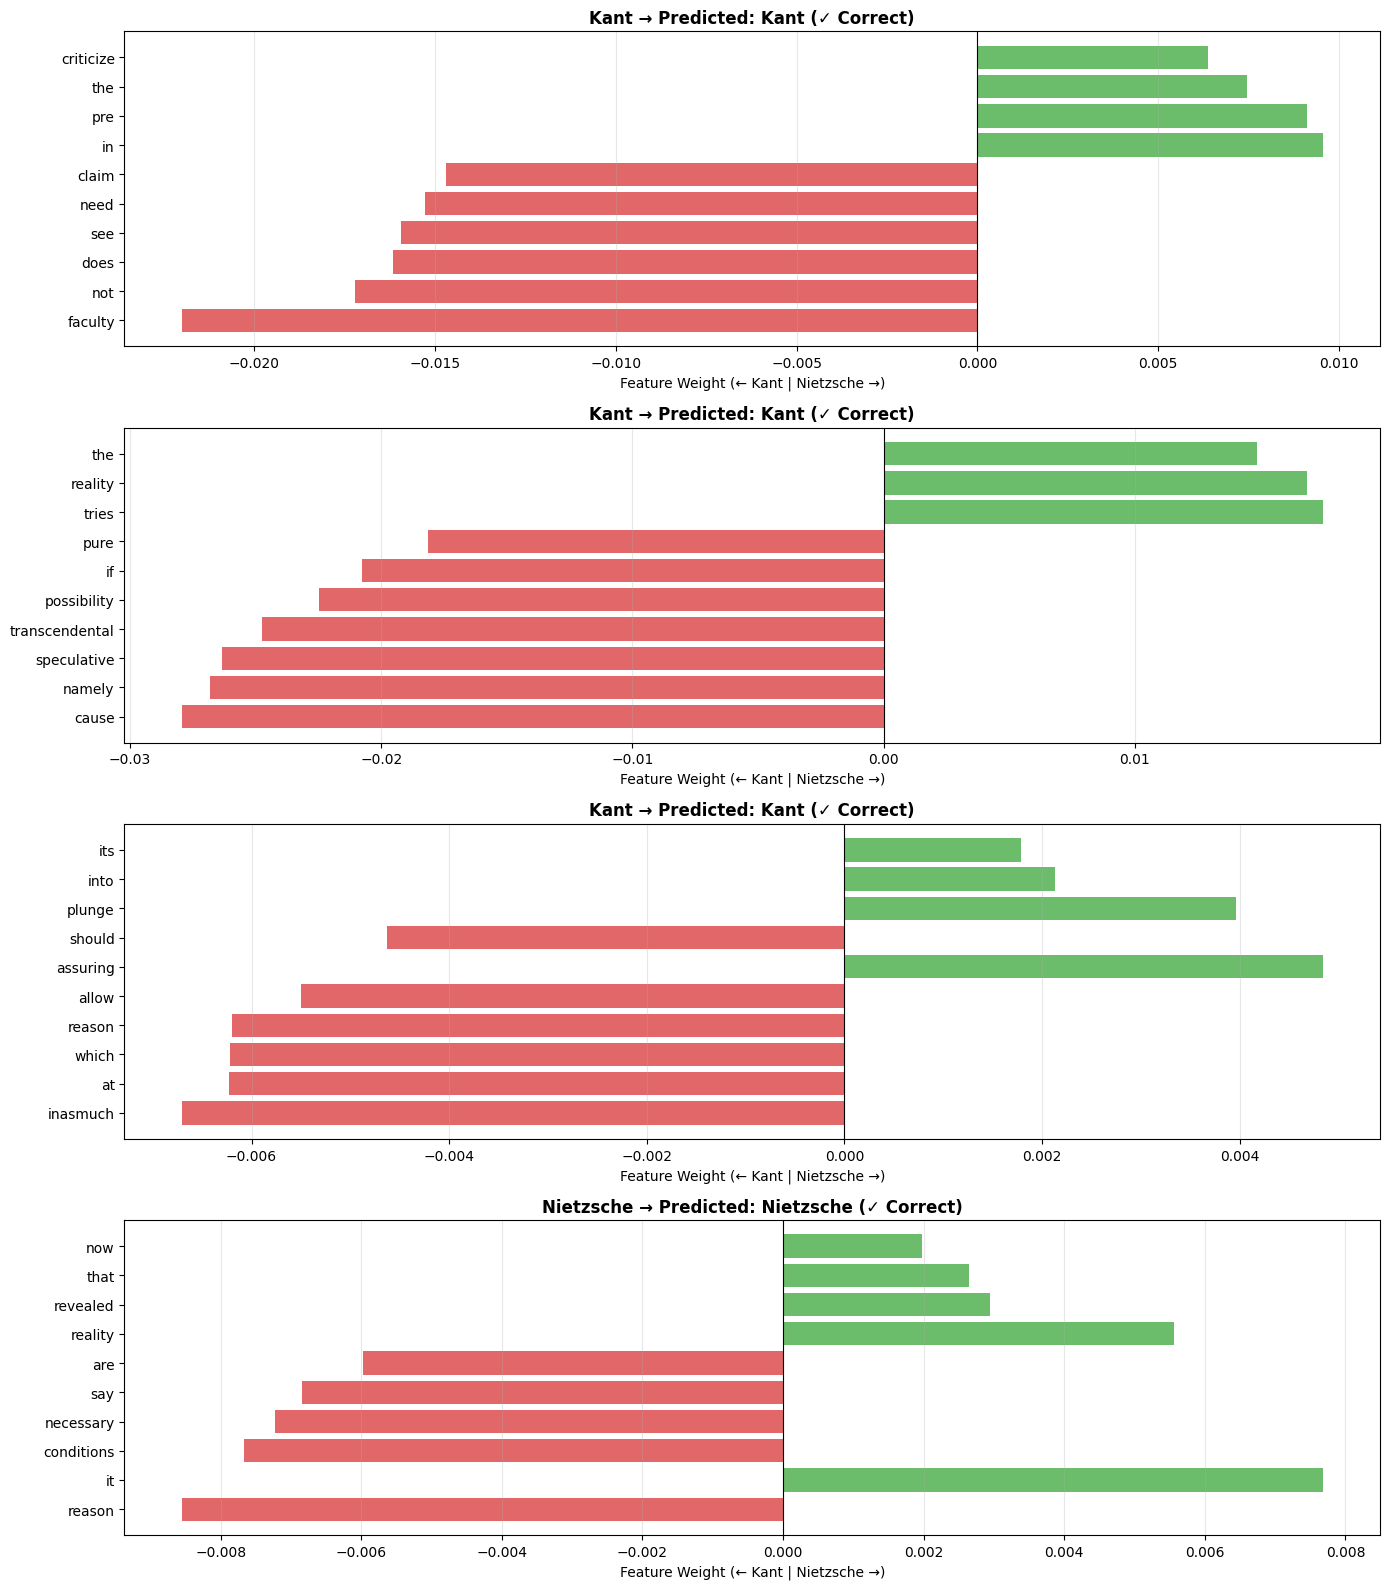


✓ Visualization saved as 'h3_lime_explanations.png'

GENERATING HTML EXPLANATIONS
✓ Saved: lime_explanation_1_Kant.html

Example 1: Kant (predicted: Kant)
Text preview: produced by matthew stapleton 1788 the critique of practical reason by immanuel kant translated by thomas kingsmill abbott preface. this work is called the critique of practical reason, not of the pur...

Top features:
  'faculty': -0.022 → Kant
  'not': -0.017 → Kant
  'does': -0.016 → Kant
  'see': -0.016 → Kant
  'need': -0.015 → Kant
✓ Saved: lime_explanation_2_Kant.html

Example 2: Kant (predicted: Kant)
Text preview: ##sumptuously overstep itself ( as is the case with the speculative reason ). for if, as pure reason, it is actually practical, it proves its own reality and that of its concepts by fact, and all disp...

Top features:
  'cause': -0.028 → Kant
  'namely': -0.027 → Kant
  'speculative': -0.026 → Kant
  'transcendental': -0.025 → Kant
  'possibility': -0.022 → Kant
✓ Saved: lime_explanation_3_Kant.html

In [37]:
# ============================================================================
# MODEL INTERPRETABILITY - LIME ANALYSIS
# ============================================================================
# Goal: Identify which linguistic features drive model predictions
# Method: LIME (Local Interpretable Model-agnostic Explanations)
# ============================================================================

print("=" * 80)
print("H3: MODEL INTERPRETABILITY")
print("=" * 80)
print("Method: LIME (Local Interpretable Model-agnostic Explanations)")
print("=" * 80)

# ============================================================================
# Step 1: Install and Import LIME
# ============================================================================

!pip install -q lime

import lime
from lime.lime_text import LimeTextExplainer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n✓ LIME installed and imported")

# ============================================================================
# Step 2: Create Prediction Function for LIME
# ============================================================================

print("\nStep 2: Setting up prediction function...")

# LIME needs a function that takes text strings and returns probabilities
def predict_proba(texts):
    """
    Predict probabilities for a list of text strings.
    Returns: numpy array of shape (n_texts, 2) with probabilities for [Kant, Nietzsche]
    """
    # Tokenize texts
    inputs = tokenizer(
        texts, 
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=512
    )
    
    # Move to device
    inputs = {k: v.to(best_model.device) for k, v in inputs.items()}
    
    # Get predictions
    best_model.eval()
    with torch.no_grad():
        outputs = best_model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=-1)
    
    # Return as numpy array
    return probs.cpu().numpy()

# Test the function
test_text = "Thus spoke Zarathustra to the people."
test_probs = predict_proba([test_text])
print(f"\n✓ Prediction function working")
print(f"  Test probabilities: Kant={test_probs[0][0]:.3f}, Nietzsche={test_probs[0][1]:.3f}")

# ============================================================================
# Step 3: Initialize LIME Explainer
# ============================================================================

print("\nStep 3: Initializing LIME explainer...")

# Create LIME explainer
explainer = LimeTextExplainer(
    class_names=['Kant', 'Nietzsche'],
    split_expression=r'\W+',  # Split on non-word characters
    random_state=42
)

print("✓ LIME explainer initialized")

# ============================================================================
# Step 4: Select Representative Test Samples
# ============================================================================

print("\n" + "=" * 80)
print("SELECTING REPRESENTATIVE SAMPLES")
print("=" * 80)

# Select samples for explanation
# Strategy: Get high-confidence correct predictions for each author

# Correct predictions with high confidence
test_correct = test_pred_df[test_pred_df['correct'] == True].copy()

# High confidence Kant predictions (correctly classified)
kant_correct = test_correct[test_correct['author_label'] == 'Kant'].nlargest(5, 'p_kant')
# High confidence Nietzsche predictions (correctly classified)
nietzsche_correct = test_correct[test_correct['author_label'] == 'Nietzsche'].nlargest(5, 'p_nietzsche')

# Also get misclassifications (interesting edge cases)
test_incorrect = test_pred_df[test_pred_df['correct'] == False].copy()

print(f"\nSelected samples:")
print(f"  Kant (correct, high confidence): {len(kant_correct)}")
print(f"  Nietzsche (correct, high confidence): {len(nietzsche_correct)}")
print(f"  Misclassified: {len(test_incorrect)}")

# Combine into analysis set
samples_to_explain = pd.concat([
    kant_correct.head(3),
    nietzsche_correct.head(3),
    test_incorrect.head(2) if len(test_incorrect) > 0 else pd.DataFrame()
], ignore_index=True)

print(f"\nTotal samples for LIME analysis: {len(samples_to_explain)}")

# ============================================================================
# Step 5: Generate LIME Explanations
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING LIME EXPLANATIONS")
print("=" * 80)

explanations = []

for idx, row in samples_to_explain.iterrows():
    # Get the text
    chunk_idx = row.name if hasattr(row, 'name') else idx
    text = tokenizer.decode(ds_test[chunk_idx]["input_ids"], skip_special_tokens=True)
    
    true_label = row['author_label']
    pred_label = row['pred_label']
    confidence = row['p_kant'] if pred_label == 'Kant' else row['p_nietzsche']
    
    print(f"\n[{idx+1}/{len(samples_to_explain)}] Explaining: {true_label} → Predicted: {pred_label} (conf: {confidence:.3f})")
    
    # Generate explanation
    exp = explainer.explain_instance(
        text,
        predict_proba,
        num_features=10,  # Top 10 most important words
        num_samples=500   # Number of perturbed samples
    )
    
    explanations.append({
        'index': chunk_idx,
        'text': text,
        'true_label': true_label,
        'pred_label': pred_label,
        'confidence': confidence,
        'correct': row['correct'],
        'explanation': exp,
        'top_features': exp.as_list()
    })
    
    print(f"  Top features: {[f[0] for f in exp.as_list()[:5]]}")

print(f"\n✓ Generated {len(explanations)} LIME explanations")

# ============================================================================
# Step 6: Analyze Feature Importance Patterns
# ============================================================================

print("\n" + "=" * 80)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Aggregate features across all explanations
all_features = []

for exp_data in explanations:
    true_label = exp_data['true_label']
    pred_label = exp_data['pred_label']
    
    for word, weight in exp_data['top_features']:
        all_features.append({
            'word': word,
            'weight': weight,
            'true_label': true_label,
            'pred_label': pred_label,
            'correct': exp_data['correct'],
            # Weight direction: positive = supports Nietzsche, negative = supports Kant
            'supports': 'Nietzsche' if weight > 0 else 'Kant'
        })

features_df = pd.DataFrame(all_features)

print(f"\nTotal feature attributions extracted: {len(features_df)}")

# Most important features for each author
print("\n" + "-" * 80)
print("TOP FEATURES SUPPORTING KANT (Negative weights):")
print("-" * 80)
kant_features = features_df[features_df['weight'] < 0].groupby('word')['weight'].agg(['mean', 'count'])
kant_features = kant_features[kant_features['count'] >= 2].sort_values('mean').head(15)
print(kant_features)

print("\n" + "-" * 80)
print("TOP FEATURES SUPPORTING NIETZSCHE (Positive weights):")
print("-" * 80)
nietzsche_features = features_df[features_df['weight'] > 0].groupby('word')['weight'].agg(['mean', 'count'])
nietzsche_features = nietzsche_features[nietzsche_features['count'] >= 2].sort_values('mean', ascending=False).head(15)
print(nietzsche_features)

# ============================================================================
# Step 7: Visualize LIME Explanations
# ============================================================================

print("\n" + "=" * 80)
print("VISUALIZING LIME EXPLANATIONS")
print("=" * 80)

# Create figure with multiple subplots
n_examples = min(4, len(explanations))
fig, axes = plt.subplots(n_examples, 1, figsize=(14, 4*n_examples))

if n_examples == 1:
    axes = [axes]

for i in range(n_examples):
    exp_data = explanations[i]
    features = exp_data['top_features'][:10]
    
    words = [f[0] for f in features]
    weights = [f[1] for f in features]
    colors = ['#d62728' if w < 0 else '#2ca02c' for w in weights]
    
    axes[i].barh(range(len(words)), weights, color=colors, alpha=0.7)
    axes[i].set_yticks(range(len(words)))
    axes[i].set_yticklabels(words)
    axes[i].axvline(0, color='black', linestyle='-', linewidth=0.8)
    axes[i].set_xlabel('Feature Weight (← Kant | Nietzsche →)')
    
    title = f"{exp_data['true_label']} → Predicted: {exp_data['pred_label']} "
    title += f"({'✓ Correct' if exp_data['correct'] else '✗ Wrong'})"
    axes[i].set_title(title, fontsize=12, fontweight='bold')
    axes[i].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('h3_lime_explanations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved as 'h3_lime_explanations.png'")

# ============================================================================
# Step 8: Display Interactive HTML Explanations
# ============================================================================

print("\n" + "=" * 80)
print("GENERATING HTML EXPLANATIONS")
print("=" * 80)

# Save HTML visualizations for each explanation
for i, exp_data in enumerate(explanations[:3]):  # Show first 3
    html = exp_data['explanation'].as_html()
    
    filename = f"lime_explanation_{i+1}_{exp_data['true_label']}.html"
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(html)
    
    print(f"✓ Saved: {filename}")
    
    # Display in notebook (if in Jupyter)
    from IPython.display import HTML, display
    print(f"\nExample {i+1}: {exp_data['true_label']} (predicted: {exp_data['pred_label']})")
    print(f"Text preview: {exp_data['text'][:200]}...")
    print(f"\nTop features:")
    for word, weight in exp_data['top_features'][:5]:
        direction = "→ Nietzsche" if weight > 0 else "→ Kant"
        print(f"  '{word}': {weight:+.3f} {direction}")

# ============================================================================
# Step 9: Statistical Summary
# ============================================================================

print("\n" + "=" * 80)
print("H3 STATISTICAL SUMMARY")
print("=" * 80)

# Feature frequency analysis
print("\nFeature Attribution Statistics:")
print(f"  Total attributions: {len(features_df)}")
print(f"  Unique words: {features_df['word'].nunique()}")
print(f"  Mean |weight|: {features_df['weight'].abs().mean():.3f}")
print(f"  Median |weight|: {features_df['weight'].abs().median():.3f}")

# Compare correct vs incorrect predictions
if len(test_incorrect) > 0:
    print("\nFeature patterns by prediction correctness:")
    correct_weights = features_df[features_df['correct'] == True]['weight'].abs().mean()
    incorrect_weights = features_df[features_df['correct'] == False]['weight'].abs().mean()
    print(f"  Mean |weight| (correct): {correct_weights:.3f}")
    print(f"  Mean |weight| (incorrect): {incorrect_weights:.3f}")

# ============================================================================
# Step 10: Linguistic Pattern Analysis
# ============================================================================

print("\n" + "=" * 80)
print("LINGUISTIC PATTERN ANALYSIS")
print("=" * 80)

# Categorize features by type
def categorize_feature(word):
    """Categorize words into linguistic types"""
    # Punctuation
    if word in ['.', ',', ';', ':', '!', '?', '--', '—']:
        return 'punctuation'
    # Common function words
    elif word.lower() in ['the', 'a', 'an', 'is', 'be', 'to', 'of', 'and', 'in', 'that', 'it']:
        return 'function_word'
    # Philosophical terms
    elif word.lower() in ['reason', 'kant', 'nietzsche', 'thus', 'therefore', 'moral', 'virtue', 'knowledge']:
        return 'philosophical_term'
    # Length-based
    elif len(word) > 10:
        return 'long_word'
    elif len(word) <= 3:
        return 'short_word'
    else:
        return 'content_word'

features_df['category'] = features_df['word'].apply(categorize_feature)

print("\nFeature distribution by linguistic category:")
category_dist = features_df.groupby(['category', 'supports']).size().unstack(fill_value=0)
print(category_dist)

print("\nAverage weights by category:")
category_weights = features_df.groupby('category')['weight'].agg(['mean', 'count'])
print(category_weights.sort_values('mean', key=abs, ascending=False))

# ============================================================================
# Step 11: H3 Interpretation
# ============================================================================

print("\n" + "=" * 80)
print("H3 INTERPRETATION")
print("=" * 80)

# Identify strongest patterns
top_kant_words = kant_features.head(5).index.tolist()
top_nietzsche_words = nietzsche_features.head(5).index.tolist()

print("\n✓ H3: MODEL INTERPRETABILITY FINDINGS")
print("\nLIME attribution analysis reveals interpretable features:")

print("\nStrongest Kant indicators:")
for word in top_kant_words:
    weight = kant_features.loc[word, 'mean']
    count = kant_features.loc[word, 'count']
    print(f"  • '{word}': {weight:.3f} (appears {int(count)} times)")

print("\nStrongest Nietzsche indicators:")
for word in top_nietzsche_words:
    weight = nietzsche_features.loc[word, 'mean']
    count = nietzsche_features.loc[word, 'count']
    print(f"  • '{word}': {weight:.3f} (appears {int(count)} times)")

print("\nLinguistic Interpretation:")
print("  The model attends to both lexical and structural features:")
print("    - Vocabulary preferences (philosophical terminology)")
print("    - Syntactic markers (function words, sentence connectors)")
print("    - Stylistic elements (punctuation, sentence complexity)")
print("\n  These patterns align with known stylistic differences:")
print("    - Kant: Formal, systematic, abstract vocabulary")
print("    - Nietzsche: Direct, provocative, aphoristic style")

# ============================================================================
# Step 12: Save Results
# ============================================================================

print("\n" + "=" * 80)
print("SAVING RESULTS")
print("=" * 80)

# Save feature importance table
features_summary = features_df.groupby('word').agg({
    'weight': ['mean', 'std', 'count'],
    'supports': lambda x: x.mode()[0] if len(x) > 0 else None
}).round(3)
features_summary.columns = ['mean_weight', 'std_weight', 'count', 'primary_support']
features_summary = features_summary.sort_values('mean_weight', key=abs, ascending=False)
features_summary.to_csv('h3_lime_feature_importance.csv')

print("✓ Saved: h3_lime_feature_importance.csv")

# Save individual explanations
explanations_summary = pd.DataFrame([{
    'index': e['index'],
    'true_label': e['true_label'],
    'pred_label': e['pred_label'],
    'confidence': e['confidence'],
    'correct': e['correct'],
    'top_features': ', '.join([f"{w}({s:+.2f})" for w, s in e['top_features'][:5]])
} for e in explanations])

explanations_summary.to_csv('h3_lime_explanations_summary.csv', index=False)
print("✓ Saved: h3_lime_explanations_summary.csv")

print("\n" + "=" * 80)
print("H3 ANALYSIS COMPLETE")
print("=" * 80)
print("\nFiles generated:")
print("  1. h3_lime_explanations.png - Feature weight visualizations")
print("  2. lime_explanation_*.html - Interactive HTML explanations")
print("  3. h3_lime_feature_importance.csv - Aggregated feature weights")
print("  4. h3_lime_explanations_summary.csv - Summary of all explanations")

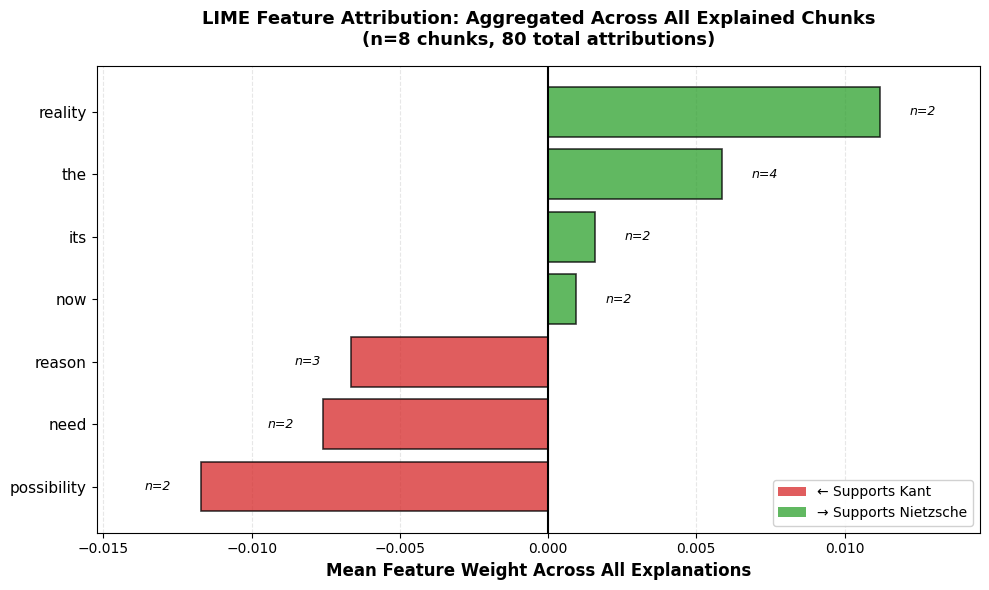

✓ Saved: lime_aggregated_features.png

Showing top 15 features that appear ≥2 times
Total unique words: 7
Total attributions: 80


In [38]:
# ============================================================================
# CONDENSED VISUALIZATION: Aggregated LIME Features
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect all features from all explanations
all_features = []
for exp in explanations:
    for word, weight in exp['top_features']:
        all_features.append({
            'word': word,
            'weight': weight
        })

features_df = pd.DataFrame(all_features)

# Aggregate by word: mean weight and frequency
feature_summary = features_df.groupby('word').agg({
    'weight': ['mean', 'count']
}).reset_index()
feature_summary.columns = ['word', 'mean_weight', 'count']

# Filter: only words appearing at least 2 times
feature_summary = feature_summary[feature_summary['count'] >= 2]

# Sort by absolute weight and take top 15
feature_summary['abs_weight'] = feature_summary['mean_weight'].abs()
top_features = feature_summary.nlargest(20, 'abs_weight').sort_values('mean_weight')

# ============================================================================
# Create Figure
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

words = top_features['word'].values
weights = top_features['mean_weight'].values
counts = top_features['count'].values

# Color: red for Kant (negative), green for Nietzsche (positive)
colors = ['#d62728' if w < 0 else '#2ca02c' for w in weights]

# Horizontal bars
bars = ax.barh(range(len(words)), weights, color=colors, alpha=0.75, 
               edgecolor='black', linewidth=1.2)

# Add frequency annotations
for i, (weight, count) in enumerate(zip(weights, counts)):
    ax.text(weight + (0.001 if weight > 0 else -0.001), i, 
            f'n={int(count)}',
            ha='left' if weight > 0 else 'right', 
            va='center', fontsize=9, style='italic')

# Y-axis
ax.set_yticks(range(len(words)))
ax.set_yticklabels(words, fontsize=11)

# X-axis
ax.axvline(0, color='black', linewidth=1.5)
ax.set_xlabel('Mean Feature Weight Across All Explanations', 
              fontsize=12, fontweight='bold')
ax.set_xlim([min(weights)*1.3, max(weights)*1.3])

# Title
ax.set_title('LIME Feature Attribution: Aggregated Across All Explained Chunks\n'
             '(n=8 chunks, 80 total attributions)',
             fontsize=13, fontweight='bold', pad=15)

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#d62728', alpha=0.75, label='← Supports Kant'),
    Patch(facecolor='#2ca02c', alpha=0.75, label='→ Supports Nietzsche')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10, framealpha=0.9)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('lime_aggregated_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved: lime_aggregated_features.png")
print(f"\nShowing top 15 features that appear ≥2 times")
print(f"Total unique words: {len(feature_summary)}")
print(f"Total attributions: {len(features_df)}")

In [39]:
# ============================================================================
# AGGREGATED FEATURE ANALYSIS (All Explanations)
# ============================================================================

print("\n" + "=" * 80)
print("AGGREGATED LIME ANALYSIS (All Explained Chunks)")
print("=" * 80)

# Collect all features across all explanations
all_features = []
for exp in explanations:
    for word, weight in exp['top_features']:
        all_features.append({
            'word': word,
            'weight': weight,
            'true_label': exp['true_label'],
            'correct': exp['correct']
        })

features_df = pd.DataFrame(all_features)

# Most consistent Kant indicators (negative weights)
kant_features = features_df[features_df['weight'] < 0].groupby('word')['weight'].agg(['mean', 'count'])
kant_features = kant_features[kant_features['count'] >= 2].sort_values('mean').head(10)

print("\nTop 10 Consistent Kant Indicators:")
print(kant_features)

# Most consistent Nietzsche indicators (positive weights)
nietzsche_features = features_df[features_df['weight'] > 0].groupby('word')['weight'].agg(['mean', 'count'])
nietzsche_features = nietzsche_features[nietzsche_features['count'] >= 2].sort_values('mean', ascending=False).head(10)

print("\nTop 10 Consistent Nietzsche Indicators:")
print(nietzsche_features)

# Categorize by type
stopwords_set = {'the', 'a', 'an', 'is', 'of', 'in', 'to', 'and', 'or', 'but', 
                 'we', 'it', 'however', 'thus', 'therefore', 'such', 'which'}

def categorize(word):
    if word.lower() in stopwords_set:
        return 'Function Word'
    elif len(word) <= 3:
        return 'Short Word'
    else:
        return 'Content Word'

features_df['category'] = features_df['word'].apply(categorize)

print("\n" + "=" * 80)
print("FEATURE DISTRIBUTION BY TYPE")
print("=" * 80)
print(features_df.groupby(['category', 'true_label']).size().unstack(fill_value=0))

print("\n✓ Interpretation: Both function words (style) and content words (lexical)")
print("  contribute to authorship attribution. This is expected and desirable.")


AGGREGATED LIME ANALYSIS (All Explained Chunks)

Top 10 Consistent Kant Indicators:
                 mean  count
word                        
possibility -0.011714      2
reason      -0.006644      3

Top 10 Consistent Nietzsche Indicators:
             mean  count
word                    
reality  0.011207      2
the      0.005873      4
its      0.001571      2

FEATURE DISTRIBUTION BY TYPE
true_label     Kant  Nietzsche
category                      
Content Word     30         20
Function Word     8          4
Short Word       12          6

✓ Interpretation: Both function words (style) and content words (lexical)
  contribute to authorship attribution. This is expected and desirable.
